In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
import math
torch.manual_seed(8)
import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP.AttentiveLayers_Sim_copy import Fingerprint, GRN, AFSE
from AttentiveFP import Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set()
from IPython.display import SVG, display
import sascorer
from AttentiveFP.utils import EarlyStopping, eval
from AttentiveFP.utils import Meter
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import AttentiveFP.Featurizer
import scipy

In [3]:
task_filename = './data/ADMET/Generation/M_C_CYP3A4_inhibitor_1.csv'
random_seed = 68
batch_size = 10
file_list1 = task_filename.split('/')
file1 = file_list1[-1]
file1 = file1[:-6]
run_number = '_run_0'
model_file = "model_file/G_ADMET_"+file1+run_number
log_dir = f'log/{"G_ADMET_"+file1}'+run_number
print(file1)
print(model_file)

M_C_CYP3A4_inhibitor
model_file/G_ADMET_M_C_CYP3A4_inhibitor_run_0


In [4]:
tasks = ['value']
task_df = pd.read_csv(task_filename, header=0, names = ["smiles", "dataset","value","cano_smiles", "dataset_generate","matched_smiles","matched_value","matched_cano_smiles"],usecols=[1,2,3,4,5,6,7,8])
task_smilesList = task_df['cano_smiles'].values
print(len(task_smilesList))
feature_filename = './features/'+model_file.split('/')[-1][:-1]+'0.pickle'
filename = './features/'+model_file.split('/')[-1]
print(feature_filename)
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
    print('Loading features successfully.')
else:
    feature_dicts = save_smiles_dicts(task_smilesList,filename)

12339
./features/G_ADMET_M_C_CYP3A4_inhibitor_run_0.pickle
Loading features successfully.


In [5]:
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

p_dropout= 0.03
fingerprint_dim = 100

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1
per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [6]:
train_df = task_df[task_df.dataset_generate.values == "training"]
train_df = train_df[train_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
train_df = train_df.reset_index(drop=True)
val_df = task_df[task_df.dataset_generate.values == "val"]
val_df = val_df[val_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
val_df = val_df.reset_index(drop=True)
test_df = task_df[task_df.dataset_generate.values == "test"]
test_df = test_df[test_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
test_df = test_df.reset_index(drop=True)
print(train_df.shape,val_df.shape,test_df.shape)

(11062, 8) (1220, 8) (51, 8)


In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([task_df["cano_smiles"].values[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
amodel = AFSE(fingerprint_dim, output_units_num, p_dropout)
gmodel = GRN(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, p_dropout)
model.cuda()
amodel.cuda()
gmodel.cuda()

optimizer = optim.Adam(params=model.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

optimizer_AFSE = optim.Adam(params=amodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# optimizer_AFSE = optim.SGD(params=amodel.parameters(), lr = 0.01, momentum=0.9)

optimizer_GRN = optim.Adam(params=gmodel.parameters(), lr=10**(-learning_rate), weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
# print(params)
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.data.shape)
        

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def sorted_show_pik(dataset, p, k, k_predict, i, acc):
    p_value = dataset[tasks[0]].astype(float).tolist()
    x = np.arange(0,len(dataset),1)
#     print('plt',dataset.head(),p[:10],k_predict,k)
#     plt.figure()
#     fig, ax1 = plt.subplots()
#     ax1.grid(False)
#     ax2 = ax1.twinx()
#     plt.grid(False)
    plt.scatter(x,p,marker='.',s=6,color='r',label='predict')
#     plt.ylabel('predict')
    plt.scatter(x,p_value,s=6,marker=',',color='blue',label='p_value')
    plt.axvline(x=k-1,ls="-",c="black")#添加垂直直线
    k_value = np.ones(len(dataset))
# #     print(EC50[k-1])
    k_value = k_value*k_predict
    plt.plot(x,k_value,'-',color='black')
    plt.ylabel('p_value')
    plt.title("epoch: {},  top-k recall: {}".format(i,acc))
    plt.legend(loc=3,fontsize=5)
    plt.show()
    

def topk_acc2(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
    
    df3 = df2[:k]  #取按预测值排完序后的前k个
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    k_true = true_sort[tasks[0]].values[k-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('k_true: ',type(k_true),k_true)
#     print('k_true: ',k_true,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=k_true,'acc_num: ',len(df3[df3['predict'].values>=k_true]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k)
    acc = len(df3[df3[tasks[0]].values>=k_true])/k #预测值前k个中真实排在前k个的个数/k
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/k
    if k>active_num:
        min_active = true_sort[tasks[0]].values[active_num-1]
        acc = len(df3[df3[tasks[0]].values>=min_active])/k
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

def topk_recall(df, predict, k, active_num, show_flag=False, i=0):
    df['predict'] = predict
    df2 = df.sort_values(by='predict',ascending=False) # 拼接预测值后对预测值进行排序
#     print('df2:\n',df2)
        
    df3 = df2[:k]  #取按预测值排完序后的前k个，因为后面的全是-4.1
    
    true_sort = df.sort_values(by=tasks[0],ascending=False) #返回一个新的按真实值排序列表
    min_active = true_sort[tasks[0]].values[active_num-1]  # 真实排第k个的活性值
#     print('df3:\n',df3['predict'])
#     print('min_active: ',type(min_active),min_active)
#     print('min_active: ',min_active,'min_predict: ',df3['predict'].values[-1],'index: ',df3['predict'].values>=min_active,'acc_num: ',len(df3[df3['predict'].values>=min_active]),
#           'fp_num: ',len(df3[df3['predict'].values>=-4.1]),'k: ',k,'active_num: ',active_num)
    acc = len(df3[df3[tasks[0]].values>-4.1])/active_num #预测值前k个中真实排在前active_num个的个数/active_num
    fp = len(df3[df3[tasks[0]].values==-4.1])/k  #预测值前k个中为-4.1的个数/active_num
    
    if(show_flag):
        #进来的是按实际活性值排好序的
        sorted_show_pik(true_sort,true_sort['predict'],k,k_predict,i,acc)
    return acc,fp

    
def topk_acc_recall(df, predict, k, active_num, show_flag=False, i=0):
    if k>active_num:
        return topk_recall(df, predict, k, active_num, show_flag, i)
    return topk_acc2(df,predict,k, active_num,show_flag,i)

def weighted_top_index(df, predict, active_num):
    weighted_acc_list=[]
    for k in np.arange(1,len(df)+1,1):
        acc, fp = topk_acc_recall(df, predict, k, active_num)
        weight = (len(df)-k)/len(df)
#         print('weight=',weight,'acc=',acc)
        weighted_acc_list.append(acc*weight)#
    weighted_acc_list = np.array(weighted_acc_list)
#     print('weighted_acc_list=',weighted_acc_list)
    return np.sum(weighted_acc_list)/weighted_acc_list.shape[0]

def AP(df, predict, active_num):
    prec = []
    rec = []
    for k in np.arange(1,len(df)+1,1):
        prec_k, fp1 = topk_acc2(df,predict,k, active_num)
        rec_k, fp2 = topk_recall(df, predict, k, active_num)
        prec.append(prec_k)
        rec.append(rec_k)
    # 取所有不同的recall对应的点处的精度值做平均
    # first append sentinel values at the end
    mrec = np.concatenate(([0.], rec, [1.]))
    mpre = np.concatenate(([0.], prec, [0.]))

    # 计算包络线，从后往前取最大保证precise非减
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # 找出所有检测结果中recall不同的点
    i = np.where(mrec[1:] != mrec[:-1])[0]
#     print(prec)
#     print('prec='+str(prec)+'\n\n'+'rec='+str(rec))

    # and sum (\Delta recall) * prec
    # 用recall的间隔对精度作加权平均
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [9]:
def caculate_r2(y,predict):
#     print(y)
#     print(predict)
    y = torch.FloatTensor(y).reshape(-1,1)
    predict = torch.FloatTensor(predict).reshape(-1,1)
    y_mean = torch.mean(y)
    predict_mean = torch.mean(predict)
    
    y1 = torch.pow(torch.mm((y-y_mean).t(),(predict-predict_mean)),2)
    y2 = torch.mm((y-y_mean).t(),(y-y_mean))*torch.mm((predict-predict_mean).t(),(predict-predict_mean))
#     print(y1,y2)
    return y1/y2

In [10]:
from torch.autograd import Variable
def l2_norm(input, dim):
    norm = torch.norm(input, dim=dim, keepdim=True)
    output = torch.div(input, norm+1e-6)
    return output

def normalize_perturbation(d,dim=-1):
    output = l2_norm(d, dim)
    return output

def tanh(x):
    return (torch.exp(x)-torch.exp(-x))/(torch.exp(x)+torch.exp(-x))

def sigmoid(x):
    return 1/(1+torch.exp(-x))

def perturb_feature(f, model, alpha=1, lamda=10**-learning_rate, output_lr=False, output_plr=False, y=None, sigmoid=False):
    mol_prediction = model(feature=f, d=0, sigmoid=sigmoid)
    pred = mol_prediction.detach()
#     f = torch.div(f, torch.norm(f, dim=-1, keepdim=True)+1e-9)
    eps = 1e-6 * normalize_perturbation(torch.randn(f.shape))
    eps = Variable(eps, requires_grad=True)
    # Predict on randomly perturbed image
    eps_p = model(feature=f, d=eps.cuda(), sigmoid=sigmoid)
    eps_p_ = model(feature=f, d=-eps.cuda(), sigmoid=sigmoid)
    p_aux = nn.Sigmoid()(eps_p/(pred+1e-6))
    p_aux_ = nn.Sigmoid()(eps_p_/(pred+1e-6))
#     loss = nn.BCELoss()(abs(p_aux),torch.ones_like(p_aux))+nn.BCELoss()(abs(p_aux_),torch.ones_like(p_aux_))
    loss = loss_function(p_aux,torch.ones_like(p_aux))+loss_function(p_aux_,torch.ones_like(p_aux_))
    loss.backward(retain_graph=True)

    # Based on perturbed image, get direction of greatest error
    eps_adv = eps.grad#/10**-learning_rate
    optimizer_AFSE.zero_grad()
    # Use that direction as adversarial perturbation
    eps_adv_normed = normalize_perturbation(eps_adv)
    d_adv = lamda * eps_adv_normed.cuda()
    if output_lr:
        f_p, max_lr = model(feature=f, d=d_adv, output_lr=output_lr, sigmoid=sigmoid)
    f_p = model(feature=f, d=d_adv, sigmoid=sigmoid)
    f_p_ = model(feature=f, d=-d_adv, sigmoid=sigmoid)
    p = nn.Sigmoid()(f_p/(pred+1e-6))
    p_ = nn.Sigmoid()(f_p_/(pred+1e-6))
    vat_loss = loss_function(p,torch.ones_like(p))+loss_function(p_,torch.ones_like(p_))
    if output_lr:
        if output_plr:
            loss = loss_function(mol_prediction,y)
            loss.backward(retain_graph=True)
            optimizer_AFSE.zero_grad()
            punish_lr = torch.norm(torch.mean(eps.grad,0))
            return eps_adv, d_adv, vat_loss, mol_prediction, max_lr, punish_lr
        return eps_adv, d_adv, vat_loss, mol_prediction, max_lr
    return eps_adv, d_adv, vat_loss, mol_prediction

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol

def d_loss(f, pred, model, y_val):
    diff_loss = 0
    length = len(pred)
    for i in range(length):
        for j in range(length):
            if j == i:
                continue
            pred_diff = model(feature_only=True, feature1=f[i], feature2=f[j])
            true_diff = y_val[i] - y_val[j]
            diff_loss += loss_function(pred_diff, torch.Tensor([true_diff]).view(-1,1))
    diff_loss = diff_loss/(length*(length-1))
    return diff_loss

In [11]:
def CE(x,y):
    c = 0
    l = len(y)
    for i in range(l):
        if y[i]==1:
            c += 1
    w1 = (l-c)/l
    w0 = c/l
    loss = -w1*y*torch.log(x+1e-6)-w0*(1-y)*torch.log(1-x+1e-6)
    loss = loss.mean(-1)
    return loss

def weighted_CE_loss(x,y):
    weight = 1/(y.detach().float().mean(0)+1e-9)
    weighted_CE = nn.CrossEntropyLoss(weight=weight)
#     atom_weights = (atom_weights-min(atom_weights))/(max(atom_weights)-min(atom_weights))
    return weighted_CE(x, torch.argmax(y,-1))

# def generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list):
#     [a,b,c] = x_atom.shape
#     [d,e,f,g] = bond_neighbor.shape
#     ce_loss = nn.CrossEntropyLoss()
#     one_hot_loss = 0
#     interger_loss = 0
#     binary_loss = 0
#     counter_i = 0
#     counter_j = 0
#     validity_mask = torch.from_numpy(validity_mask).cuda()
#     for i in range(a):
#         l = (x_atom[i].sum(-1)!=0).sum(-1)
#         one_hot_loss += weighted_CE_loss(refer_atom_list[i,:l,:16], x_atom[i,:l,:16]) - \
#                         ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1)/(validity_mask[i,:l].sum(-1)+1e-9)).mean(-1).mean(-1)+\
#                          weighted_CE_loss(refer_atom_list[i,:l,16:22], x_atom[i,:l,16:22])+ \
#                          weighted_CE_loss(refer_atom_list[i,:l,24:30], x_atom[i,:l,24:30])+ \
#                          weighted_CE_loss(refer_atom_list[i,:l,31:36], x_atom[i,:l,31:36])
#         interger_loss += loss_function(refer_atom_list[i,:l,23], x_atom[i,:l,23])+ \
#                         loss_function(refer_atom_list[i,:l,24], x_atom[i,:l,24])
#         binary_loss += CE(refer_atom_list[i,:l,30], x_atom[i,:l,30])+ \
#                         CE(refer_atom_list[i,:l,36], x_atom[i,:l,36])+ \
#                         CE(refer_atom_list[i,:l,37], x_atom[i,:l,37])+ \
#                         CE(refer_atom_list[i,:l,38], x_atom[i,:l,38])
#         counter_i += 1
#         for j in range(l):
#             n = (bond_neighbor[i,j].sum(-1)!=0).sum(-1)
#             if n==0:
#                 continue
#             one_hot_loss += weighted_CE_loss(refer_bond_list[i,j,:n,:4], bond_neighbor[i,j,:n,:4])+ \
#                              weighted_CE_loss(refer_bond_list[i,j,:n,6:], bond_neighbor[i,j,:n,6:])
#             binary_loss += CE(refer_bond_list[i,j,:n,4], bond_neighbor[i,j,:n,4])+ \
#                            CE(refer_bond_list[i,j,:n,5], bond_neighbor[i,j,:n,5])
#             counter_j += 1
#     one_hot_loss = one_hot_loss/(5*counter_i+2*counter_j)
#     interger_loss = interger_loss/(2*counter_i)
#     binary_loss = binary_loss/(4*counter_i+2*counter_j)
#     total_loss = (one_hot_loss + interger_loss + binary_loss)/3
#     return total_loss, one_hot_loss, interger_loss, binary_loss


def generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list):
    [a,b,c] = x_atom.shape
    [d,e,f,g] = bond_neighbor.shape
    ce_loss = nn.CrossEntropyLoss()
    one_hot_loss = 0
    run_times = 0
    validity_mask = torch.from_numpy(validity_mask).cuda()
    for i in range(a):
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        atom_weights = 1/x_atom[i,:l,:16].mean(-2)
        ce_atom_loss = nn.CrossEntropyLoss(weight=atom_weights)
        one_hot_loss += ce_atom_loss(refer_atom_list[i,:l,:16], torch.argmax(x_atom[i,:l,:16],-1))- \
                         ((validity_mask[i,:l]*torch.log(1-atom_list[i,:l,:16]+1e-9)).sum(-1)/(validity_mask[i,:l].sum(-1)+1e-9)).mean(-1).mean(-1)
        run_times += 2
    total_loss = one_hot_loss/run_times
    return total_loss, 0, 0, 0


def train(model, amodel, gmodel, dataset, test_df, optimizer_list, loss_function, epoch):
    model.train()
    amodel.train()
    gmodel.train()
    optimizer, optimizer_AFSE, optimizer_GRN = optimizer_list
    np.random.seed(epoch)
    max_len = np.max([len(dataset),len(test_df)])
    valList = np.arange(0,max_len)
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, max_len, batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch%len(dataset),:]
        batch_test = test_df.loc[batch%len(test_df),:]
        global_step = epoch * len(batch_list) + counter
        smiles_list = batch_df.cano_smiles.values
        smiles_list_test = batch_test.cano_smiles.values
        y_val = batch_df[tasks[0]].values.astype(float)
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        x_atom_test, x_bonds_test, x_atom_index_test, x_bond_index_test, x_mask_test, smiles_to_rdkit_list_test = get_smiles_array(smiles_list_test,feature_dicts)
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),
                                                  torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),
                                                  mol_feature=mol_feature,activated_features=activated_features)
        
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        eps_adv, d_adv, vat_loss, mol_prediction, conv_lr, punish_lr = perturb_feature(mol_feature, amodel, alpha=1, 
                                                                                       lamda=10**-learning_rate, output_lr=True, 
                                                                                       output_plr=True, y=torch.Tensor(y_val).view(-1,1),
                                                                                       sigmoid=True) # 10**-learning_rate     
        classification_loss = - torch.Tensor(y_val).view(-1,1) * torch.log(mol_prediction) - \
                                (1-torch.Tensor(y_val).view(-1,1)) * torch.log(1-mol_prediction)
        classification_loss = torch.mean(classification_loss)
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/(1e-9),activated_features=activated_features)
        success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=1, global_step=global_step)
        reconstruction_loss, one_hot_loss, interger_loss,binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, 
                                                                                              bond_neighbor, validity_mask, atom_list, 
                                                                                              bond_list)
#         x_atom_test = torch.Tensor(x_atom_test)
#         x_bonds_test = torch.Tensor(x_bonds_test)
#         x_bond_index_test = torch.cuda.LongTensor(x_bond_index_test)
        
#         bond_neighbor_test = [x_bonds_test[i][x_bond_index_test[i]] for i in range(len(batch_test))]
#         bond_neighbor_test = torch.stack(bond_neighbor_test, dim=0)
#         activated_features_test, mol_feature_test = model(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                           torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),
#                                                           torch.Tensor(x_mask_test),output_activated_features=True)
#         mol_feature_test = torch.div(mol_feature_test, torch.norm(mol_feature_test, dim=-1, keepdim=True)+1e-9)
#         activated_features_test = torch.div(activated_features_test, torch.norm(activated_features_test, dim=-1, keepdim=True)+1e-9)
#         eps_test, d_test, test_vat_loss, mol_prediction_test = perturb_feature(mol_feature_test, amodel, 
#                                                                                     alpha=1, lamda=10**-learning_rate)
#         atom_list_test, bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),torch.cuda.LongTensor(x_atom_index_test),
#                                                 torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                 mol_feature=mol_feature_test+d_test/1e-6,activated_features=activated_features_test.detach())
#         refer_atom_list_test, refer_bond_list_test = gmodel(torch.Tensor(x_atom_test),torch.Tensor(x_bonds_test),
#                                                             torch.cuda.LongTensor(x_atom_index_test),torch.cuda.LongTensor(x_bond_index_test),torch.Tensor(x_mask_test),
#                                                             mol_feature=mol_feature_test,activated_features=activated_features_test.detach())
#         success_smiles_batch_test, modified_smiles_test, success_batch_test, total_batch_test, reconstruction_test, validity_test, validity_mask_test = modify_atoms(smiles_list_test, x_atom_test, 
#                             bond_neighbor_test, atom_list_test, bond_list_test,smiles_list_test,smiles_to_rdkit_list_test,
#                                                      refer_atom_list_test, refer_bond_list_test,topn=1)
#         test_reconstruction_loss, test_one_hot_loss, test_interger_loss,test_binary_loss = generate_loss_function(atom_list_test, x_atom_test, bond_list_test, bond_neighbor_test, validity_mask_test, atom_list_test, bond_list_test)
        
        if vat_loss>1:
            vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())    
#         if vat_loss>1 or test_vat_loss>1:
#             vat_loss = 1*(vat_loss/(vat_loss+1e-6).item())
#             test_vat_loss = 1*(test_vat_loss/(test_vat_loss+1e-6).item())
        
        max_lr = 1e-3
        conv_lr = conv_lr - conv_lr**2 + 0.06 * punish_lr # 0.06
        if conv_lr < max_lr and conv_lr >= 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = conv_lr.detach()
                AFSE_lr = conv_lr    
        elif conv_lr < 0:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = 0
                AFSE_lr = 0
        elif conv_lr >= max_lr:
            for param_group in optimizer_AFSE.param_groups:
                param_group["lr"] = max_lr
                AFSE_lr = max_lr
        
        logger.add_scalar('loss/classification', classification_loss, global_step)
        logger.add_scalar('loss/AFSE', vat_loss, global_step)
#         logger.add_scalar('loss/AFSE_test', test_vat_loss, global_step)
        logger.add_scalar('loss/GRN', reconstruction_loss, global_step)
#         logger.add_scalar('loss/GRN_test', test_reconstruction_loss, global_step)
        logger.add_scalar('loss/GRN_one_hot', one_hot_loss, global_step)
        logger.add_scalar('loss/GRN_interger', interger_loss, global_step)
        logger.add_scalar('loss/GRN_binary', binary_loss, global_step)
        logger.add_scalar('lr/max_lr', conv_lr, global_step)
        logger.add_scalar('lr/punish_lr', punish_lr, global_step)
        logger.add_scalar('lr/AFSE_lr', AFSE_lr, global_step)
    
        optimizer.zero_grad()
        optimizer_AFSE.zero_grad()
        optimizer_GRN.zero_grad()
        loss =  classification_loss + vat_loss + reconstruction_loss
        loss.backward()
        optimizer.step()
        optimizer_AFSE.step()
        optimizer_GRN.step()
        
def clear_atom_map(mol):
    [a.ClearProp('molAtomMapNumber') for a  in mol.GetAtoms()]
    return mol

def mol_with_atom_index( mol ):
    atoms = mol.GetNumAtoms()
    for idx in range( atoms ):
        mol.GetAtomWithIdx( idx ).SetProp( 'molAtomMapNumber', str( mol.GetAtomWithIdx( idx ).GetIdx() ) )
    return mol
        
def modify_atoms(smiles, x_atom, bond_neighbor, atom_list, bond_list, y_smiles, smiles_to_rdkit_list,refer_atom_list, 
                 refer_bond_list,topn=1, print_flag=False, global_step=0):
    x_atom = x_atom.cpu().detach().numpy()
    bond_neighbor = bond_neighbor.cpu().detach().numpy()
    atom_list = atom_list.cpu().detach().numpy()
    bond_list = bond_list.cpu().detach().numpy()
    refer_atom_list = refer_atom_list.cpu().detach().numpy()
    refer_bond_list = refer_bond_list.cpu().detach().numpy()
    atom_symbol_sorted = np.argsort(x_atom[:,:,:16], axis=-1)
    atom_symbol_generated_sorted = np.argsort(atom_list[:,:,:16], axis=-1)
    generate_confidence_sorted = np.sort(atom_list[:,:,:16], axis=-1)
    init_smiles = []
    modified_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    recon_rate = 0
    total_atom = 0
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    confidence_threshold = 0.001
    validity_mask = np.zeros_like(atom_list[:,:,:16])
    symbol_list = ['B','C','N','O','F','Si','P','S','Cl','As','Se','Br','Te','I','At','other']
    symbol_to_rdkit = [4,6,7,8,9,14,15,16,17,33,34,35,52,53,85,0]
    for i in range(len(atom_list)):
        rank = 0
        top_idx = 0
        flag = 0
        first_run_flag = True
        l = (x_atom[i].sum(-1)!=0).sum(-1)
        cano_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(smiles[i]))
        mol = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
        counter = 0
        for j in range(l): 
            if mol.GetAtomWithIdx(int(smiles_to_rdkit_list[cano_smiles][j])).GetAtomicNum() == \
                symbol_to_rdkit[refer_atom_list[i,j,:16].argmax(-1)]:
                counter += 1
            if print_flag:
                print(f'atom#{smiles_to_rdkit_list[cano_smiles][j]}(f):',{symbol_list[k]: np.around(refer_atom_list[i,j,k],3) for k in range(16)},
                      f'\natom#{smiles_to_rdkit_list[cano_smiles][j]}(f+d):',{symbol_list[k]: np.around(atom_list[i,j,k],3) for k in range(16)},
                     '\n------------------------------------------------------------------------------------------------------------')
#                 print(f'atom#{smiles_to_rdkit_list[cano_smiles][j]}(f):',{symbol_list[k]: refer_atom_list[i,j,k] for k in range(16)},
#                       f'\natom#{smiles_to_rdkit_list[cano_smiles][j]}(f+d):',{symbol_list[k]: atom_list[i,j,k] for k in range(16)},
#                      '\n------------------------------------------------------------------------------------------------------------')
#         print('预测为每个原子的平均概率：\n',np.around(atom_list[i,:l,:16].mean(1),2))
#         print('预测为每个原子的最大概率：\n',np.around(atom_list[i,:l,:16].max(1),2))
        recon_rate += counter
        total_atom += l
        if counter == l:
            success_reconstruction += 1
        while not flag==topn:
            if rank == 16:
                rank = 0
                top_idx += 1
            if top_idx == l:
                if print_flag:
                    print('No molecule that meets the conditions is generated.')
                flag += 1
                continue
#             if np.sum((atom_symbol_sorted[i,:l,-1]!=atom_symbol_generated_sorted[i,:l,-1-rank]).astype(int))==0:
#                 print(f'根据预测的第{rank}大概率的原子构成的分子与原分子一致，原子位重置为0，生成下一个元素……')
#                 rank += 1
#                 top_idx = 0
#                 generate_index = np.argsort((atom_list[i,:l,:16]-refer_atom_list[i,:l,:16] -\
#                                              x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            if print_flag:
                print('i:',i,'top_idx:', top_idx, 'rank:',rank)
            if rank == 0:
                generate_index = np.argsort((atom_list[i,:l,:16]-refer_atom_list[i,:l,:16] -\
                                             x_atom[i,:l,:16]).max(-1))[-1-top_idx]
            atom_symbol_generated = np.argsort(atom_list[i,generate_index,:16]-\
                                                    refer_atom_list[i,generate_index,:16] -\
                                                    x_atom[i,generate_index,:16])[-1-rank]
            if atom_symbol_generated==x_atom[i,generate_index,:16].argmax(-1):
                if print_flag:
                    print('The same element is generated, generating the next element ...')
                rank += 1
                continue
            generate_rdkit_index = smiles_to_rdkit_list[cano_smiles][generate_index]
            if np.sort(atom_list[i,generate_index,:16]-x_atom[i,generate_index,:16])[-1-rank]<confidence_threshold or symbol_list[atom_symbol_generated]=='other':
                if print_flag:
                    print(f'The confidence of generating {symbol_list[atom_symbol_generated]} elements on the {generate_rdkit_index}-th atom is less than {confidence_threshold}, finding the next atom...')
                top_idx += 1
                rank = 0
                continue
#             if symbol_to_rdkit[atom_symbol_generated]==6:
#                 print('生成了不推荐的C元素')
#                 rank += 1
#                 continue
            mol.GetAtomWithIdx(int(generate_rdkit_index)).SetAtomicNum(symbol_to_rdkit[atom_symbol_generated])
            print_mol = mol
            try:
                Chem.SanitizeMol(mol)
                if first_run_flag == True:
                    success_validity += 1
                total[flag] += 1
                if Chem.MolToSmiles(clear_atom_map(print_mol))==y_smiles[i]:
                    success[flag] +=1
                    if print_flag:
                        print('Congratulations!', success, total)
                    success_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                mol_init = mol_with_atom_index(Chem.MolFromSmiles(smiles[i]))
                init_smiles.append(smiles[i])
                modified_smiles.append(Chem.MolToSmiles(clear_atom_map(print_mol)))
                if print_flag:
                    print("Molecule known to be highly toxic:\n>>> "+smiles[i])
                    display(mol_init)
                    print(f"To optimize the above molecule to be less toxic, GAFSE Modifies the <{generate_rdkit_index}>-th atom to the element of <{symbol_list[atom_symbol_generated]}> with the probability of <{np.sort(atom_list[i,generate_index,:16])[-1-rank]:.3f}>:\n>>> "+Chem.MolToSmiles(clear_atom_map(print_mol)))
                    display(mol_with_atom_index(mol))
                    mol_y = mol_with_atom_index(Chem.MolFromSmiles(y_smiles[i]))
                    print("Molecule known to have lower toxicity:\n>>> "+y_smiles[i])
                    display(mol_y)
                rank += 1
                flag += 1
            except:
                if print_flag:
                    print(f"Modifying the {generate_rdkit_index}-th atom to the element of {symbol_list[atom_symbol_generated]} does not meet the specification, generating the next element...")
                rank += 1
                validity_mask[i,generate_index,atom_symbol_generated] = 1
                first_run_flag = False
    recon_rate = recon_rate/total_atom
    if global_step > 0:
        logger.add_scalar('acc/recon_rate', recon_rate, global_step)
    return success_smiles, init_smiles, modified_smiles, success, total, success_reconstruction, success_validity, validity_mask
        
def eval(model, amodel, gmodel, dataset, topn=1, output_feature=False, generate=False, modify_atom=True,return_GRN_loss=False, 
         viz=False, print_flag=False, validate=False):
    model.eval()
    amodel.eval()
    gmodel.eval()
    predict_list = []
    test_MSE_list = []
    r2_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    feature_list = []
    d_list = []
    success = [0 for i in range(topn)]
    total = [0 for i in range(topn)]
    init_smiles_list = []
    generated_smiles = []
    success_smiles = []
    success_reconstruction = 0
    success_validity = 0
    reconstruction_loss, one_hot_loss, interger_loss, binary_loss = [0,0,0,0]
    
# #     取dataset中排序后的第k个
#     sorted_dataset = dataset.sort_values(by=tasks[0],ascending=False)
#     k_df = sorted_dataset.iloc[[k-1]]
#     k_smiles = k_df['smiles'].values
#     k_value = k_df[tasks[0]].values.astype(float)    
    
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
#     print(batch_list)
    for counter, batch in enumerate(batch_list):
#         print(type(batch))
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        if generate and validate:
            matched_smiles_list = batch_df.matched_cano_smiles.values
        else:
            matched_smiles_list = smiles_list
#         print(batch_df)
        y_val = batch_df[tasks[0]].values.astype(float)
#         print(type(y_val))
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(matched_smiles_list,feature_dicts)
        x_atom = torch.Tensor(x_atom)
        x_bonds = torch.Tensor(x_bonds)
        x_bond_index = torch.cuda.LongTensor(x_bond_index)
        bond_neighbor = [x_bonds[i][x_bond_index[i]] for i in range(len(batch_df))]
        bond_neighbor = torch.stack(bond_neighbor, dim=0)
        
        lamda=10**-learning_rate
        activated_features, mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),output_activated_features=True)
#         mol_feature = torch.div(mol_feature, torch.norm(mol_feature, dim=-1, keepdim=True)+1e-9)
#         activated_features = torch.div(activated_features, torch.norm(activated_features, dim=-1, keepdim=True)+1e-9)
        eps_adv, d_adv, vat_loss, mol_prediction = perturb_feature(mol_feature, amodel, alpha=1, lamda=lamda, sigmoid=True)
#         print(mol_feature,d_adv)
        atom_list, bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),
                                      torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),
                                      torch.Tensor(x_mask),mol_feature=mol_feature+d_adv/(1e-12),activated_features=activated_features)
        refer_atom_list, refer_bond_list = gmodel(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask),mol_feature=mol_feature,activated_features=activated_features)
        if generate:
            if modify_atom:     
                success_smiles_batch, init_smiles, modified_smiles, success_batch, total_batch, reconstruction, validity, validity_mask = modify_atoms(matched_smiles_list, x_atom, 
                            bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list,
                                                     refer_atom_list, refer_bond_list,topn=topn, print_flag=print_flag)
            else:
                modified_smiles = modify_bonds(matched_smiles_list, x_atom, bond_neighbor, atom_list, bond_list,smiles_list,smiles_to_rdkit_list)
            init_smiles_list.extend(init_smiles)
            generated_smiles.extend(modified_smiles)
            success_smiles.extend(success_smiles_batch)
            reconstruction_loss, one_hot_loss, interger_loss, binary_loss = generate_loss_function(refer_atom_list, x_atom, refer_bond_list, bond_neighbor, validity_mask, atom_list, bond_list)
            for n in range(topn):
                success[n] += success_batch[n]
                total[n] += total_batch[n]
            if print_flag:
                print('congratulations:',success,total)
            success_reconstruction += reconstruction
            success_validity += validity
        d = d_adv.cpu().detach().numpy().tolist()
        d_list.extend(d)
        mol_feature_output = mol_feature.cpu().detach().numpy().tolist()
        feature_list.extend(mol_feature_output)
        predict_list.extend(mol_prediction.cpu().detach().numpy())
        
    if generate:
        generated_num = len(generated_smiles)
        eval_num = len(dataset)
        unique = generated_num
        novelty = generated_num
        for i in range(generated_num):
            for j in range(generated_num-i-1):
                if generated_smiles[i]==generated_smiles[i+j+1]:
                    unique -= 1
            for k in range(eval_num):
                if generated_smiles[i]==dataset['smiles'].values[k]:
                    novelty -= 1
        unique_rate = unique/(generated_num+1e-9)
        novelty_rate = novelty/(generated_num+1e-9)
        if print_flag:
            print(f'successfully/total generated molecules =', {f'Top-{i+1}': f'{success[i]}/{total[i]}' for i in range(topn)})
        return success_reconstruction/len(dataset), success_validity/len(dataset), unique_rate, novelty_rate, success_smiles, init_smiles_list, generated_smiles,predict_list
    if return_GRN_loss:
        return d_list, feature_list, predict_list,reconstruction_loss, one_hot_loss, interger_loss,binary_loss
    if output_feature:
        return d_list, feature_list,predict_list
    return predict_list

epoch = 0
max_epoch = 2000
batch_size = 10
patience = 200
# stopper = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_model.pth')
# stopper_afse = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_amodel.pth')
# stopper_generate = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_gmodel.pth')

stopper = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_model_test.pth')
stopper_afse = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_amodel_test.pth')
stopper_generate = EarlyStopping(mode='higher', patience=patience, filename=model_file + '_gmodel_test.pth')

In [12]:
# import datetime
# from tensorboardX import SummaryWriter
# now = datetime.datetime.now().strftime('%b%d_%H-%M-%S')
# if os.path.isdir(log_dir):
#     for files in os.listdir(log_dir):
#         os.remove(log_dir+"/"+files)
#     os.rmdir(log_dir)
# logger = SummaryWriter(log_dir)
# print(log_dir)

In [13]:
# optimizer_list = [optimizer, optimizer_AFSE, optimizer_GRN]
# while epoch < max_epoch:
#     train(model, amodel, gmodel, train_df, test_df, optimizer_list, loss_function, epoch)
# #     print(train_df.shape,test_df.shape)
#     train_recon, train_validity, train_unique, train_novelty, _, _, _, train_predict = eval(model, amodel, gmodel, train_df, topn=1, generate=True)
#     val_recon, val_validity, val_unique, val_novelty, _, _, _, val_predict = eval(model, amodel, gmodel, val_df, topn=1, generate=True)
    
#     test_recon, test_validity, test_unique, test_novelty, _, _, _, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True)

#     global_step = epoch * int(np.max([len(train_df),len(test_df)])/batch_size)
#     logger.add_scalar('val/reconstruction', val_recon, global_step)
#     logger.add_scalar('val/validity', val_validity, global_step)
#     logger.add_scalar('val/unique', val_unique, global_step)
#     logger.add_scalar('val/novelty', val_novelty, global_step)
#     logger.add_scalar('test/reconstruction', test_recon, global_step)
#     logger.add_scalar('test/validity', test_validity, global_step)
#     logger.add_scalar('test/unique', test_unique, global_step)
#     logger.add_scalar('test/novelty', test_novelty, global_step)
    
#     val_average = (val_recon+val_validity+val_unique+val_novelty)/4
#     test_average = (test_recon+test_validity+test_unique+test_novelty)/4
#     epoch = epoch + 1
#     global_step = epoch * int(np.max([len(train_df),len(test_df)])/batch_size)
#     early_stop = stopper.step(val_average, model)
#     early_stop = stopper_afse.step(val_average, amodel, if_print=False)
#     early_stop = stopper_generate.step(val_average, gmodel, if_print=False)
# #     print('epoch {:d}/{:d}, validation {} {:.4f}, {} {:.4f},best validation {r2} {:.4f}'.format(epoch, total_epoch, 'r2', val_r2, 'mse:',val_MSE, stopper.best_score))
#     print(epoch, 'Rec: %.4f'%train_recon,'%.4f'%val_recon,'%.4f'%test_recon, 'Vali: %.4f'%val_validity,'%.4f'%test_validity,
#          'Uni: %.2f'%val_unique,'%.2f'%test_unique, 'Nov: %.2f'%val_novelty,'%.2f'%test_novelty,
#          'Avg: %.4f'%val_average,'%.4f'%test_average)
#     if early_stop:
#         continue


atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#28(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#28(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#31(f): {'B': 0.0, '

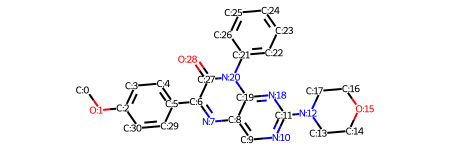

To optimize the above molecule to be less toxic, GAFSE Modifies the <1>-th atom to the element of <C> with the probability of <1.000>:
>>> CCc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(-c3ccccc3)c2=O)cc1


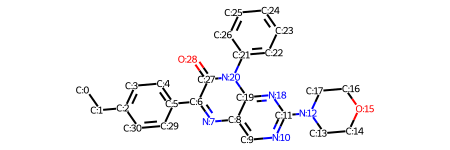

Molecule known to have lower toxicity:
>>> COc1ccc(-c2nc3cnc(N4CCNCC4)nc3n(-c3ccccc3)c2=O)cc1


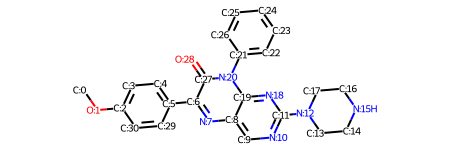

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.055, 'C': 0.078, 'N': 0.001, 'O': 0.002, 'F': 0.099, 'Si': 0.11, 'P': 0.053, 'S': 0.042, 'Cl': 0.065, 'As': 0.057, 'Se': 0.109, 'Br': 0.027, 'Te': 0.063, 'I': 0.054, 'At': 0.055, 'other': 0.13} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.055, 'C': 0.079, 'N': 0.001, 'O': 0.002, 'F': 0.099, 'Si': 0.11, 'P': 0.053, 'S': 0.041, 'Cl': 0.065, 'As': 0.057, 'Se': 0.109, 'Br': 0.027, 'Te': 0.063, 'I': 0.054, 'At': 0.055, 'other': 0.13} 
---------------------------------------------------------------------------------

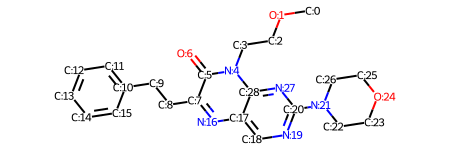

To optimize the above molecule to be less toxic, GAFSE Modifies the <4>-th atom to the element of <S> with the probability of <0.291>:
>>> COCC[SH]1C(=O)C(CCc2ccccc2)NC2CNC(N3CCOCC3)NC21


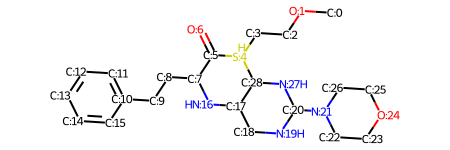

Molecule known to have lower toxicity:
>>> COCCn1c(=O)c(CCc2ccccc2)nc2cnc(N3CCNCC3)nc21


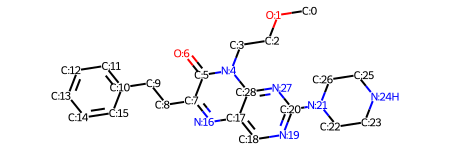

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.114, 'P': 0.055, 'S': 0.044, 'Cl': 0.057, 'As': 0.058, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.114, 'P': 0.055, 'S': 0.044, 'Cl': 0.057, 'As': 0.058, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
-------------------------------------------------------------------------------

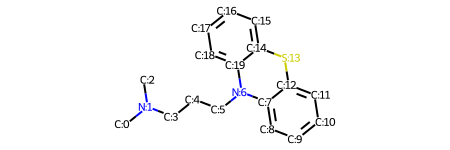

To optimize the above molecule to be less toxic, GAFSE Modifies the <3>-th atom to the element of <I> with the probability of <1.000>:
>>> CN(C)[IH]CCN1c2ccccc2Sc2ccccc21


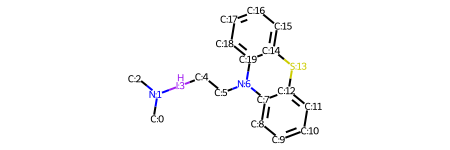

Molecule known to have lower toxicity:
>>> CN(C)CCCN1c2ccccc2Sc2cnccc21


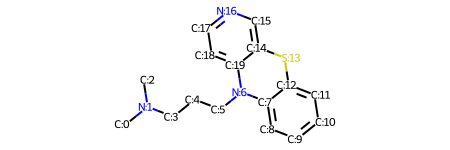

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.047, 'C': 0.092, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.049, 'S': 0.035, 'Cl': 0.089, 'As': 0.048, 'Se': 0.1, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.054, 'other': 0.13} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#12(f+d): {'B': 0.047, 'C': 0.091, 'N': 0.0, 'O': 0.002, 'F': 0.115, 'Si': 0.115, 'P': 0.049, 'S': 0.035, 'Cl': 0.091, 'As': 0.048, 'Se': 0.099, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.054, 'other': 0.13} 
-----------------------------------------------------------------------------------

atom#19(f): {'B': 0.0, 'C': 0.991, 'N': 0.0, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.006, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#19(f+d): {'B': 0.047, 'C': 0.092, 'N': 0.0, 'O': 0.002, 'F': 0.115, 'Si': 0.115, 'P': 0.049, 'S': 0.035, 'Cl': 0.089, 'As': 0.048, 'Se': 0.1, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.054, 'other': 0.13} 
------------------------------------------------------------------------------------------------------------
i: 4 top_idx: 0 rank: 0
Modifying the 28-th atom to the element of C does not meet the specification, generating the next element...
i: 4 top_idx: 0 rank: 1
The confidence of generating S elements on the 28-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 1 rank: 0
The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 2 rank: 0
The confidence of generating other elements on the 4-th atom is less t

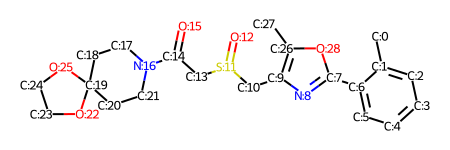

To optimize the above molecule to be less toxic, GAFSE Modifies the <7>-th atom to the element of <Si> with the probability of <0.521>:
>>> Cc1ccccc1[SiH]1CC(C)C(CS(=O)CC(=O)N2CCC3(CC2)OCCO3)N1


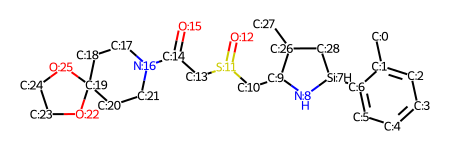

Molecule known to have lower toxicity:
>>> Cc1oc(-c2ccccc2F)nc1CS(=O)CC(=O)N1CCC2(CC1)OCCO2


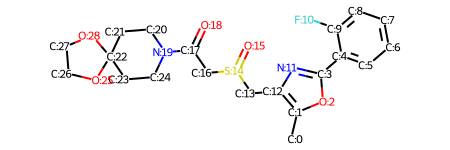

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.

atom#6(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#8(f): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#8(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#9(f): {'B': 0

atom#4(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.053, 'C': 0.073, 'N': 0.001, 'O': 0.002, 'F': 0.104, 'Si': 0.114, 'P': 0.054, 'S': 0.043, 'Cl': 0.065, 'As': 0.056, 'Se': 0.108, 'Br': 0.026, 'Te': 0.062, 'I': 0.055, 'At': 0.056, 'other': 0.129} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.053, 'C': 0.073, 'N': 0.001, 'O': 0.002, 'F': 0.104, 'Si': 0.114, 'P': 0.054, 'S': 0.043, 'Cl': 0.064, 'As': 0.057, 'Se': 0.108, 'Br': 0.026, 'Te': 0.062, 'I': 0.055, 'At': 0.056, 'other': 0.129} 
-----------------------------------------------------------------------

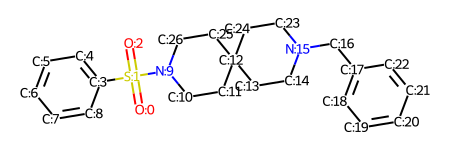

To optimize the above molecule to be less toxic, GAFSE Modifies the <15>-th atom to the element of <C> with the probability of <0.524>:
>>> O=S(=O)(c1ccccc1)N1CCC2(CCC(Cc3ccccc3)CC2)CC1


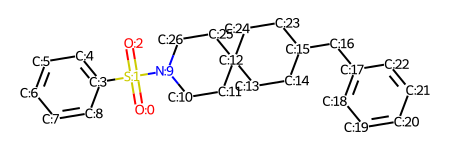

Molecule known to have lower toxicity:
>>> O=S(=O)(c1ccccc1)N1CCC2(CCN(Cc3ccncc3)CC2)CC1


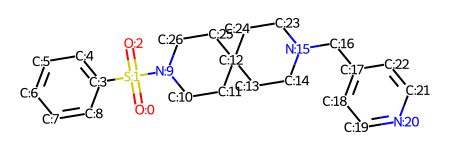

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.05, 'C': 0.088, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.116, 'P': 0.05, 'S': 0.034, 'Cl': 0.084, 'As': 0.049, 'Se': 0.102, 'Br': 0.024, 'Te': 0.051, 'I': 0.054, 'At': 0.053, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.05, 'C': 0.089, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.116, 'P': 0.05, 'S': 0.034, 'Cl': 0.083, 'As': 0.049, 'Se': 0.103, 'Br': 0.023, 'Te': 0.051, 'I': 0.054, 'At': 0.053, 'other': 0.133} 
-----------------------------------------------------------------------------------

atom#31(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#31(f+d): {'B': 0.05, 'C': 0.089, 'N': 0.0, 'O': 0.002, 'F': 0.109, 'Si': 0.116, 'P': 0.05, 'S': 0.034, 'Cl': 0.082, 'As': 0.049, 'Se': 0.103, 'Br': 0.023, 'Te': 0.051, 'I': 0.054, 'At': 0.053, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#32(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#32(f+d): {'B': 0.05, 'C': 0.088, 'N': 0.0, 'O': 0.002, 'F': 0.109, 'Si': 0.116, 'P': 0.05, 'S': 0.034, 'Cl': 0.082, 'As': 0.049, 'Se': 0.103, 'Br': 0.023, 'Te': 0.051, 'I': 0.054, 'At': 0.053, 'other': 0.133} 
---------------------------------------------------------------------------

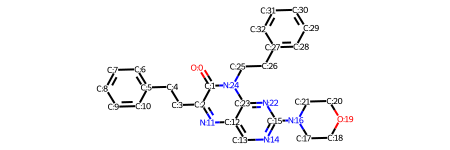

To optimize the above molecule to be less toxic, GAFSE Modifies the <19>-th atom to the element of <C> with the probability of <1.000>:
>>> O=c1c(CCc2ccccc2)nc2cnc(N3CCCCC3)nc2n1CCc1ccccc1


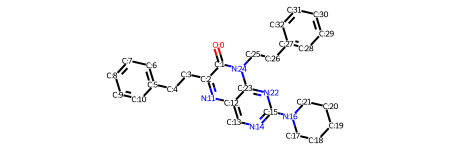

Molecule known to have lower toxicity:
>>> O=c1c(CCc2ccccc2)nc2cnc(N3CCNCC3)nc2n1CCc1ccccc1


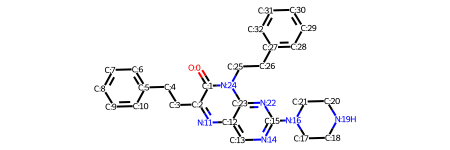

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.041, 'C': 0.178, 'N': 0.001, 'O': 0.058, 'F': 0.064, 'Si': 0.086, 'P': 0.081, 'S': 0.042, 'Cl': 0.107, 'As': 0.035, 'Se': 0.066, 'Br': 0.015, 'Te': 0.028, 'I': 0.073, 'At': 0.019, 'other': 0.104} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.996, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.042, 'C': 0.171, 'N': 0.001, 'O': 0.057, 'F': 0.064, 'Si': 0.088, 'P': 0.081, 'S': 0.042, 'Cl': 0.108, 'As': 0.036, 'Se': 0.066, 'Br': 0.015, 'Te': 0.029, 'I': 0.074, 'At': 0.02, 'other': 0.105} 
------------------------------------------------------------------------------

Modifying the 3-th atom to the element of C does not meet the specification, generating the next element...
i: 8 top_idx: 3 rank: 1
Modifying the 3-th atom to the element of Cl does not meet the specification, generating the next element...
i: 8 top_idx: 3 rank: 2
The confidence of generating other elements on the 3-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 4 rank: 0
The confidence of generating other elements on the 25-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 5 rank: 0
The confidence of generating other elements on the 11-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 6 rank: 0
The confidence of generating other elements on the 21-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 7 rank: 0
The confidence of generating other elements on the 22-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 8 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, 

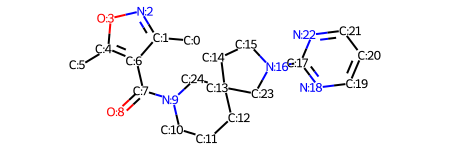

To optimize the above molecule to be less toxic, GAFSE Modifies the <2>-th atom to the element of <C> with the probability of <0.664>:
>>> CC1CCC(C)C1C(=O)N1CCCC2(CCN(c3ncccn3)C2)C1


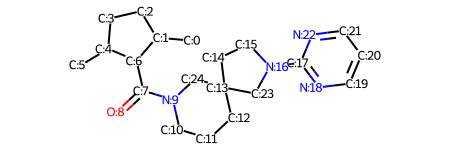

Molecule known to have lower toxicity:
>>> Cc1noc(C)c1C(=O)N1CCCC2(CCN(c3ccccn3)C2)C1


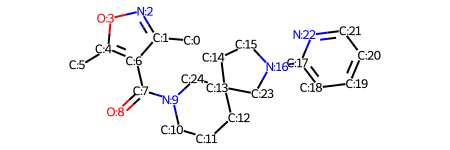

congratulations: [0] [7]
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.046, 'C': 0.097, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.116, 'P': 0.05, 'S': 0.034, 'Cl': 0.091, 'As': 0.046, 'Se': 0.099, 'Br': 0.022, 'Te': 0.048, 'I': 0.052, 'At': 0.054, 'other': 0.128} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.046, 'C': 0.098, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.116, 'P': 0.05, 'S': 0.035, 'Cl': 0.089, 'As': 0.046, 'Se': 0.1, 'Br': 0.022, 'Te': 0.048, 'I': 0.052, 'At': 0.054, 'other': 0.128} 
--------------------------------------------------------

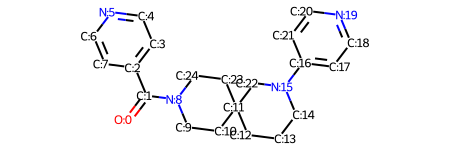

To optimize the above molecule to be less toxic, GAFSE Modifies the <19>-th atom to the element of <C> with the probability of <1.000>:
>>> O=C(c1ccncc1)N1CCC2(CCCN(c3ccccc3)C2)CC1


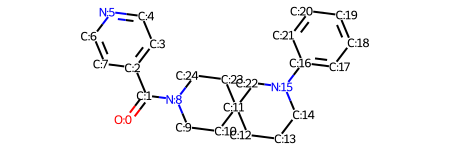

Molecule known to have lower toxicity:
>>> O=C(c1ccncc1)N1CCC2(CCCN(c3ccccc3)C2)CC1


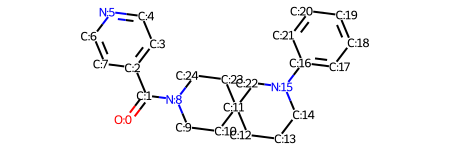

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0

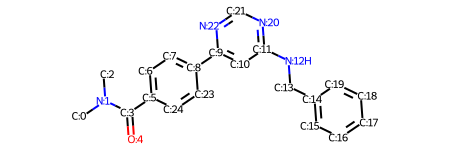

To optimize the above molecule to be less toxic, GAFSE Modifies the <12>-th atom to the element of <C> with the probability of <0.525>:
>>> CN(C)C(=O)c1ccc(-c2cc(CCc3ccccc3)ncn2)cc1


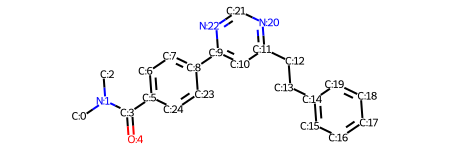

Molecule known to have lower toxicity:
>>> CN(C)C(=O)c1ccc(-c2cc(NCc3cccnc3)ncn2)cc1


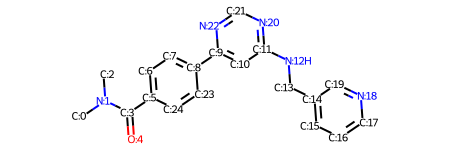

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.054, 'C': 0.075, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.108, 'P': 0.054, 'S': 0.049, 'Cl': 0.058, 'As': 0.057, 'Se': 0.11, 'Br': 0.027, 'Te': 0.063, 'I': 0.053, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.996, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.054, 'C': 0.076, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.108, 'P': 0.054, 'S': 0.049, 'Cl': 0.058, 'As': 0.057, 'Se': 0.109, 'Br': 0.027, 'Te': 0.063, 'I': 0.053, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------------------------------

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.06, 'C': 0.072, 'N': 0.001, 'O': 0.003, 'F': 0.105, 'Si': 0.116, 'P': 0.059, 'S': 0.033, 'Cl': 0.051, 'As': 0.059, 'Se': 0.104, 'Br': 0.033, 'Te': 0.059, 'I': 0.06, 'At': 0.061, 'other': 0.125} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.06, 'C': 0.071, 'N': 0.002, 'O': 0.003, 'F': 0.105, 'Si': 0.117, 'P': 0.06, 'S': 0.031, 'Cl': 0.05, 'As': 0.059, 'Se': 0.104, 'Br': 0.033, 'Te': 0.059, 'I': 0.06, 'At': 0.062, 'other': 0.125} 
-----------------------------------------------------------------------------------

>>> COCCn1c(=O)c(-c2ccc(Cl)cc2)nc2cnc(N3CCOCC3)nc21


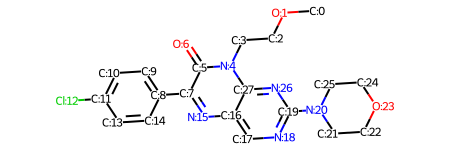

To optimize the above molecule to be less toxic, GAFSE Modifies the <23>-th atom to the element of <C> with the probability of <1.000>:
>>> COCCn1c(=O)c(-c2ccc(Cl)cc2)nc2cnc(N3CCCCC3)nc21


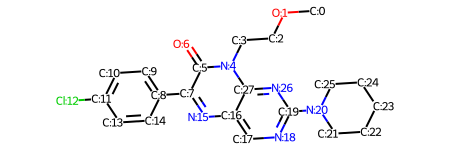

Molecule known to have lower toxicity:
>>> COCCn1c(=O)c(-c2ccc(Cl)cc2)nc2cnc(N3CCNCC3)nc21


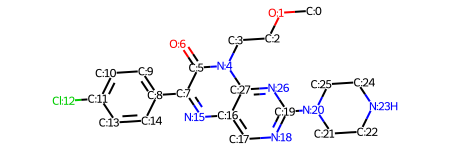

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.051, 'C': 0.083, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.115, 'P': 0.05, 'S': 0.033, 'Cl': 0.086, 'As': 0.049, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.001, 'C': 0.013, 'N': 0.031, 'O': 0.027, 'F': 0.875, 'Si': 0.001, 'P': 0.001, 'S': 0.017, 'Cl': 0.026, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
atom#7(f+d): {'B': 0.051, 'C': 0.083, 'N': 0.0, 'O': 0.002, 'F': 0.112, 'Si': 0.115, 'P': 0.05, 'S': 0.033, 'Cl': 0.085, 'As': 0.049, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.131} 
---------------------------------------------------------

atom#1(f+d): {'B': 0.051, 'C': 0.084, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.115, 'P': 0.05, 'S': 0.034, 'Cl': 0.085, 'As': 0.049, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.132} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.051, 'C': 0.084, 'N': 0.0, 'O': 0.002, 'F': 0.112, 'Si': 0.115, 'P': 0.05, 'S': 0.033, 'Cl': 0.085, 'As': 0.049, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.132} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0

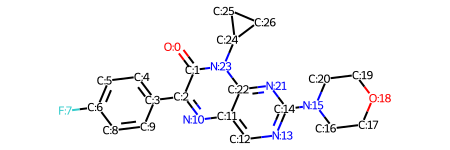

To optimize the above molecule to be less toxic, GAFSE Modifies the <13>-th atom to the element of <C> with the probability of <1.000>:
>>> O=c1c(-c2ccc(F)cc2)nc2ccc(N3CCOCC3)nc2n1C1CC1


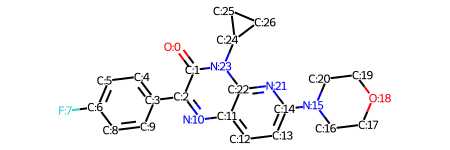

Molecule known to have lower toxicity:
>>> O=c1c(-c2ccc(F)cc2)nc2cnc(N3CCNCC3)nc2n1C1CC1


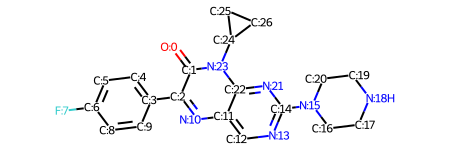

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.054, 'C': 0.073, 'N': 0.001, 'O': 0.003, 'F': 0.096, 'Si': 0.114, 'P': 0.052, 'S': 0.032, 'Cl': 0.08, 'As': 0.057, 'Se': 0.11, 'Br': 0.027, 'Te': 0.062, 'I': 0.057, 'At': 0.055, 'other': 0.128} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 1.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
at

Molecule known to be highly toxic:
>>> COCCn1c(=O)c(-c2ccc(OC)cc2)nc2cnc(N3CCOCC3)nc21


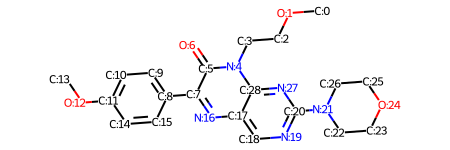

To optimize the above molecule to be less toxic, GAFSE Modifies the <6>-th atom to the element of <I> with the probability of <1.000>:
>>> COCCn1c(=[IH])c(-c2ccc(OC)cc2)nc2cnc(N3CCOCC3)nc21


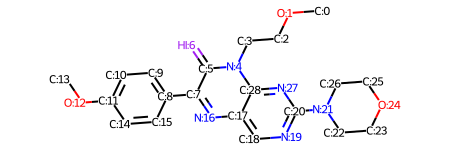

Molecule known to have lower toxicity:
>>> COCCn1c(=O)c(-c2ccc(OC)cc2)nc2cnc(N3CCNCC3)nc21


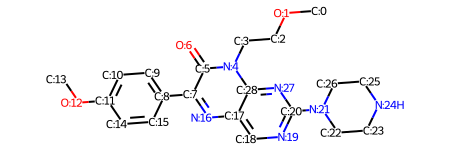

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.002, 'F': 0.103, 'Si': 0.114, 'P': 0.055, 'S': 0.043, 'Cl': 0.058, 'As': 0.058, 'Se': 0.11, 'Br': 0.027, 'Te': 0.064, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.002, 'F': 0.103, 'Si': 0.114, 'P': 0.055, 'S': 0.043, 'Cl': 0.058, 'As': 0.058, 'Se': 0.11, 'Br': 0.027, 'Te': 0.064, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
---------------------------------------------------------------------------------

atom#1(f): {'B': 0.0, 'C': 0.0, 'N': 0.997, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.002, 'F': 0.103, 'Si': 0.114, 'P': 0.054, 'S': 0.043, 'Cl': 0.058, 'As': 0.058, 'Se': 0.109, 'Br': 0.027, 'Te': 0.063, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.004, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.054, 'C': 0.071, 'N': 0.001, 'O': 0.002, 'F': 0.103, 'Si': 0.114, 'P': 0.055, 'S': 0.043, 'Cl': 0.058, 'As': 0.058, 'Se': 0.11, 'Br': 0.027, 'Te': 0.064, 'I': 0.056, 'At': 0.055, 'other': 0.131} 
------------------------------------------------------------------------------

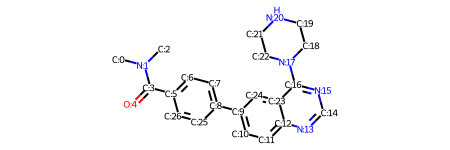

To optimize the above molecule to be less toxic, GAFSE Modifies the <17>-th atom to the element of <C> with the probability of <0.523>:
>>> CN(C)C(=O)c1ccc(-c2ccc3ncnc(C4CCNCC4)c3c2)cc1


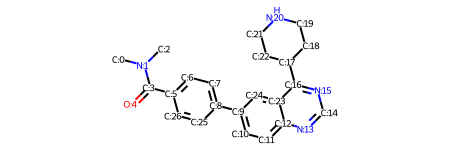

Molecule known to have lower toxicity:
>>> CN(C)C(=O)c1ccc(-c2ccc3ncnc(N4CCOCC4)c3c2)cc1


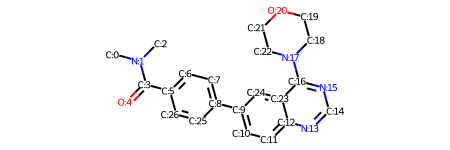

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.058, 'C': 0.069, 'N': 0.002, 'O': 0.002, 'F': 0.101, 'Si': 0.107, 'P': 0.057, 'S': 0.057, 'Cl': 0.051, 'As': 0.061, 'Se': 0.106, 'Br': 0.029, 'Te': 0.064, 'I': 0.057, 'At': 0.054, 'other': 0.125} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.058, 'C': 0.069, 'N': 0.002, 'O': 0.002, 'F': 0.101, 'Si': 0.107, 'P': 0.057, 'S': 0.057, 'Cl': 0.051, 'As': 0.061, 'Se': 0.106, 'Br': 0.029, 'Te': 0.064, 'I': 0.056, 'At': 0.054, 'other': 0.126} 
---------------------------------------------------------------------------

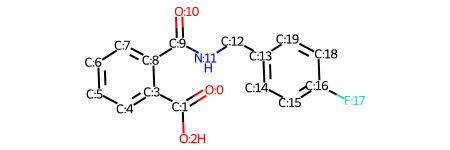

To optimize the above molecule to be less toxic, GAFSE Modifies the <11>-th atom to the element of <C> with the probability of <0.646>:
>>> O=C(O)c1ccccc1C(=O)CCc1ccc(F)cc1


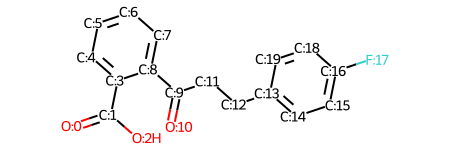

Molecule known to have lower toxicity:
>>> O=C(O)c1ccccc1C(=O)NNc1ccc(F)cc1


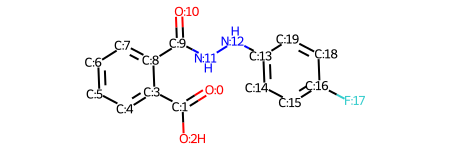

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.046, 'C': 0.101, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.115, 'P': 0.05, 'S': 0.036, 'Cl': 0.088, 'As': 0.046, 'Se': 0.1, 'Br': 0.022, 'Te': 0.048, 'I': 0.052, 'At': 0.055, 'other': 0.125} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.047, 'C': 0.099, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.115, 'P': 0.05, 'S': 0.035, 'Cl': 0.089, 'As': 0.046, 'Se': 0.099, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.055, 'other': 0.125} 
-------------------------------------------------------------------------------------

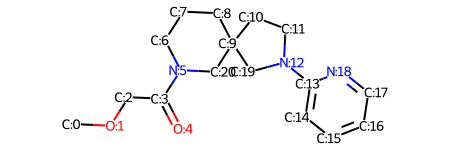

To optimize the above molecule to be less toxic, GAFSE Modifies the <18>-th atom to the element of <C> with the probability of <1.000>:
>>> COCC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1


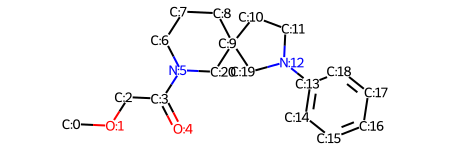

Molecule known to have lower toxicity:
>>> COCC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1


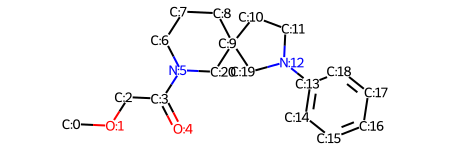

congratulations: [2] [15]
atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.053, 'C': 0.072, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.112, 'P': 0.055, 'S': 0.043, 'Cl': 0.06, 'As': 0.057, 'Se': 0.109, 'Br': 0.026, 'Te': 0.063, 'I': 0.055, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#5(f+d): {'B': 0.053, 'C': 0.072, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.112, 'P': 0.055, 'S': 0.043, 'Cl': 0.061, 'As': 0.057, 'Se': 0.109, 'Br': 0.026, 'Te': 0.063, 'I': 0.055, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------

atom#9(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#9(f+d): {'B': 0.053, 'C': 0.071, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.112, 'P': 0.055, 'S': 0.044, 'Cl': 0.059, 'As': 0.058, 'Se': 0.109, 'Br': 0.026, 'Te': 0.063, 'I': 0.055, 'At': 0.055, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#12(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#12(f+d): {'B': 0.005, 'C': 0.523, 'N': 0.05, 'O': 0.007, 'F': 0.042, 'Si': 0.01, 'P': 0.008, 'S': 0.291, 'Cl': 0.006, 'As': 0.009, 'Se': 0.006, 'Br': 0.002, 'Te': 0.003, 'I': 0.017, 'At': 0.009, 'other': 0.013} 
---------------------------------------------------------------------------

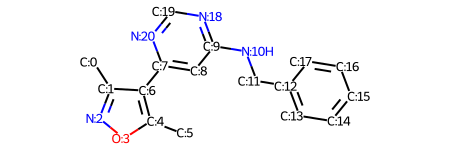

To optimize the above molecule to be less toxic, GAFSE Modifies the <10>-th atom to the element of <C> with the probability of <0.523>:
>>> Cc1noc(C)c1-c1cc(CCc2ccccc2)ncn1


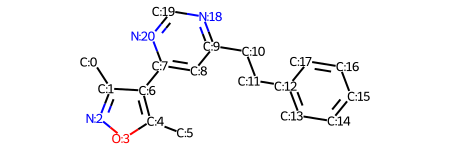

Molecule known to have lower toxicity:
>>> Cc1noc(C)c1-c1cc(NCc2cccnc2)ncn1


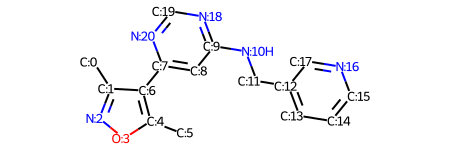

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0

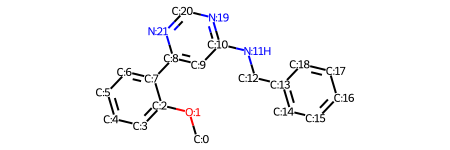

To optimize the above molecule to be less toxic, GAFSE Modifies the <11>-th atom to the element of <S> with the probability of <0.431>:
>>> COc1ccccc1-c1cc(SCc2ccccc2)ncn1


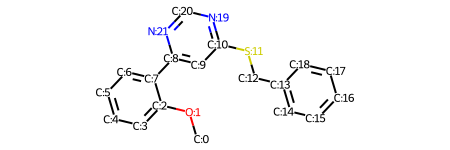

Molecule known to have lower toxicity:
>>> COc1ccccc1-c1cc(NCc2cccnc2)ncn1


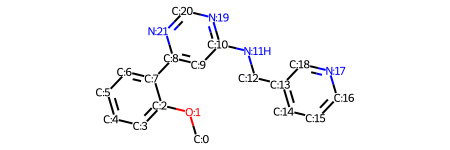

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#28(f): {'B': 0.001, 'C': 0.013, 'N': 0.03, 'O': 0.026, 'F': 0.879, 'Si': 0.001, 'P': 0.001, 'S': 0.017, 'Cl': 0.025, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.001} 
atom#28(f+d): {'B': 0.001, 'C': 0.013, 'N': 0.03, 'O': 0.026, 'F': 0.879, 'Si': 0.001, 'P': 0.001, 'S': 0.017, 'Cl': 0.025, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.001} 
-------------------------------------------------------------------------------

atom#1(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.049, 'C': 0.082, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.05, 'S': 0.036, 'Cl': 0.087, 'As': 0.049, 'Se': 0.1, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#11(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#

>>> CCc1cccc2c(C=C(C#N)C#N)cn(CC(=O)N3CCCCC3)c12


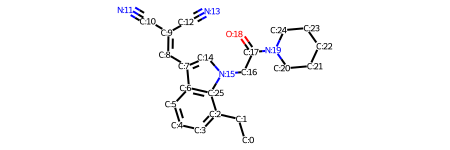

To optimize the above molecule to be less toxic, GAFSE Modifies the <11>-th atom to the element of <C> with the probability of <1.000>:
>>> C#CC(C#N)=Cc1cn(CC(=O)N2CCCCC2)c2c(CC)cccc12


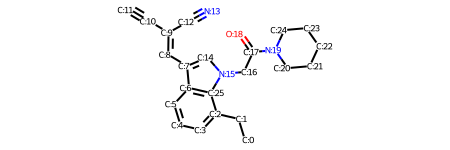

Molecule known to have lower toxicity:
>>> CCc1cccc2c(C=C(C#N)C#N)cn(CC(=O)N3CCCCCC3)c12


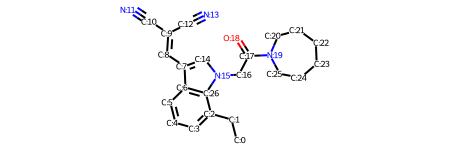

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.053, 'C': 0.079, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.111, 'P': 0.052, 'S': 0.042, 'Cl': 0.066, 'As': 0.056, 'Se': 0.109, 'Br': 0.026, 'Te': 0.062, 'I': 0.053, 'At': 0.055, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.053, 'C': 0.078, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.111, 'P': 0.052, 'S': 0.042, 'Cl': 0.065, 'As': 0.056, 'Se': 0.109, 'Br': 0.026, 'Te': 0.062, 'I': 0.053, 'At': 0.055, 'other': 0.133} 
-------------------------------------------------------------------------

atom#15(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.053, 'C': 0.078, 'N': 0.001, 'O': 0.001, 'F': 0.102, 'Si': 0.111, 'P': 0.053, 'S': 0.042, 'Cl': 0.065, 'As': 0.056, 'Se': 0.11, 'Br': 0.026, 'Te': 0.062, 'I': 0.053, 'At': 0.055, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#16(f): {'B': 0.0, 'C': 0.0, 'N': 0.997, 'O': 0.0, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#16(f+d): {'B': 0.053, 'C': 0.078, 'N': 0.001, 'O': 0.001, 'F': 0.103, 'Si': 0.111, 'P': 0.052, 'S': 0.043, 'Cl': 0.065, 'As': 0.056, 'Se': 0.109, 'Br': 0.026, 'Te': 0.062, 'I': 0.053, 'At': 0.055, 'other': 0.133} 
----------------------------------------------------------------------------

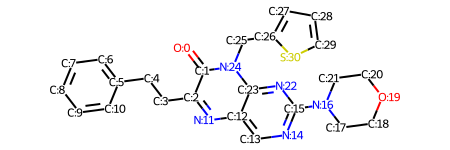

To optimize the above molecule to be less toxic, GAFSE Modifies the <24>-th atom to the element of <C> with the probability of <0.387>:
>>> O=C1C(CCc2ccccc2)NC2CNC(N3CCOCC3)NC2C1Cc1cccs1


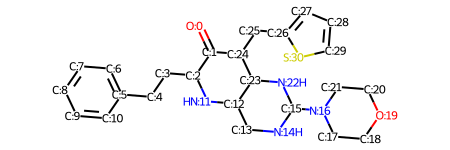

Molecule known to have lower toxicity:
>>> O=c1c(CCc2ccccc2)nc2cnc(N3CCNCC3)nc2n1Cc1cccs1


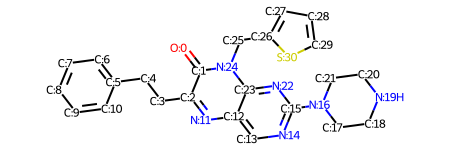

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 1.0, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#25(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#25(f+d): {'B': 0.048, 'C': 0.11, 'N': 0.0, 'O': 0.002, 'F': 0.102, 'Si': 0.111, 'P': 0.051, 'S': 0.038, 'Cl': 0.075, 'As': 0.047, 'Se': 0.099, 'Br': 0.022, 'Te': 0.053, 'I': 0.051, 'At': 0.057, 'other': 0.135} 
------------------------------------------------------------------------------------------------------------
a

atom#19(f+d): {'B': 0.047, 'C': 0.112, 'N': 0.0, 'O': 0.001, 'F': 0.101, 'Si': 0.11, 'P': 0.051, 'S': 0.039, 'Cl': 0.074, 'As': 0.047, 'Se': 0.099, 'Br': 0.022, 'Te': 0.053, 'I': 0.05, 'At': 0.057, 'other': 0.135} 
------------------------------------------------------------------------------------------------------------
atom#20(f): {'B': 0.0, 'C': 0.0, 'N': 0.997, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#20(f+d): {'B': 0.048, 'C': 0.109, 'N': 0.0, 'O': 0.001, 'F': 0.102, 'Si': 0.111, 'P': 0.051, 'S': 0.038, 'Cl': 0.074, 'As': 0.047, 'Se': 0.099, 'Br': 0.022, 'Te': 0.053, 'I': 0.051, 'At': 0.057, 'other': 0.136} 
------------------------------------------------------------------------------------------------------------
atom#21(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I':

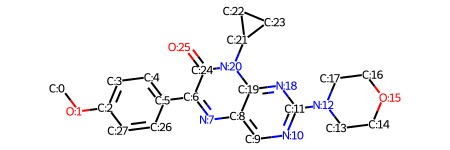

To optimize the above molecule to be less toxic, GAFSE Modifies the <1>-th atom to the element of <C> with the probability of <0.815>:
>>> CCc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)cc1


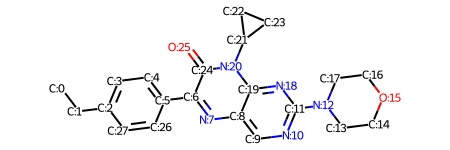

Molecule known to have lower toxicity:
>>> COc1ccc(-c2nc3cnc(N4CCNCC4)nc3n(C3CC3)c2=O)cc1


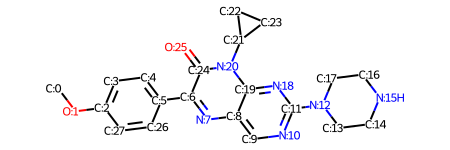

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.051, 'C': 0.082, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.05, 'S': 0.035, 'Cl': 0.083, 'As': 0.05, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.056, 'At': 0.053, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.051, 'C': 0.08, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.05, 'S': 0.034, 'Cl': 0.085, 'As': 0.05, 'Se': 0.102, 'Br': 0.025, 'Te': 0.051, 'I': 0.056, 'At': 0.054, 'other': 0.131} 
--------------------------------------------------------------------------------------

atom#28(f+d): {'B': 0.051, 'C': 0.081, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.05, 'S': 0.034, 'Cl': 0.084, 'As': 0.05, 'Se': 0.103, 'Br': 0.025, 'Te': 0.051, 'I': 0.056, 'At': 0.053, 'other': 0.132} 
------------------------------------------------------------------------------------------------------------
i: 7 top_idx: 0 rank: 0
Molecule known to be highly toxic:
>>> COCCn1c(=O)c(-c2cccc(C#N)c2)nc2cnc(N3CCOCC3)nc21


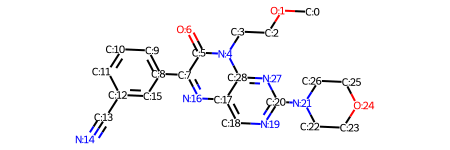

To optimize the above molecule to be less toxic, GAFSE Modifies the <14>-th atom to the element of <C> with the probability of <1.000>:
>>> C#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(CCOC)c2=O)c1


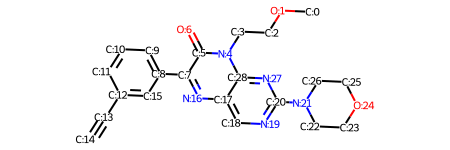

Molecule known to have lower toxicity:
>>> COCCn1c(=O)c(-c2cccc(C#N)c2)nc2cnc(N3CCNCC3)nc21


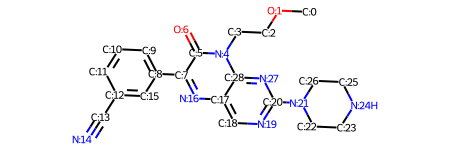

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#11(f): {'B': 0.0,

atom#28(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#29(f): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#29(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.0, 'N': 0.997, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 

atom#20(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#20(f+d): {'B': 0.051, 'C': 0.078, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.117, 'P': 0.051, 'S': 0.04, 'Cl': 0.071, 'As': 0.052, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.053, 'other': 0.138} 
------------------------------------------------------------------------------------------------------------
atom#22(f): {'B': 0.0, 'C': 0.0, 'N': 0.996, 'O': 0.0, 'F': 0.003, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#22(f+d): {'B': 0.051, 'C': 0.078, 'N': 0.0, 'O': 0.002, 'F': 0.115, 'Si': 0.117, 'P': 0.051, 'S': 0.04, 'Cl': 0.071, 'As': 0.052, 'Se': 0.103, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.053, 'other': 0.138} 
-----------------------------------------------------------------------------

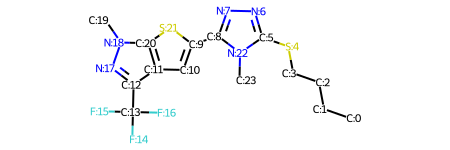

To optimize the above molecule to be less toxic, GAFSE Modifies the <15>-th atom to the element of <C> with the probability of <1.000>:
>>> CCCCSc1nnc(-c2cc3c(C(C)(F)F)nn(C)c3s2)n1C


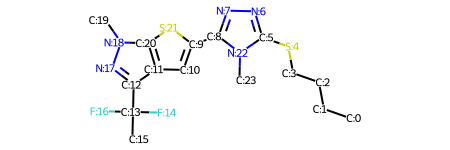

Molecule known to have lower toxicity:
>>> C#CCSc1nnc(-c2cc3c(C(F)(F)F)nn(C)c3s2)n1C


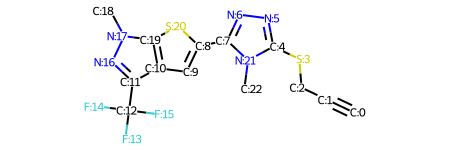

congratulations: [2] [22]
atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.049, 'C': 0.092, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.116, 'P': 0.05, 'S': 0.035, 'Cl': 0.084, 'As': 0.048, 'Se': 0.102, 'Br': 0.023, 'Te': 0.051, 'I': 0.054, 'At': 0.054, 'other': 0.13} 
------------------------------------------------------------------------------------------------------------
atom#2(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#2(f+d): {'B': 0.049, 'C': 0.092, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.116, 'P': 0.05, 'S': 0.035, 'Cl': 0.083, 'As': 0.048, 'Se': 0.102, 'Br': 0.023, 'Te': 0.051, 'I': 0.054, 'At': 0.054, 'other': 0.131} 
----------------------------------------------------------

The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 8 rank: 0
The confidence of generating other elements on the 2-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 9 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 10 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 11 rank: 0
The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 12 rank: 0
The confidence of generating other elements on the 1-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 13 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 14 rank: 0
The confidence of generating other elements on the 19-th atom is less than 0.001, fin

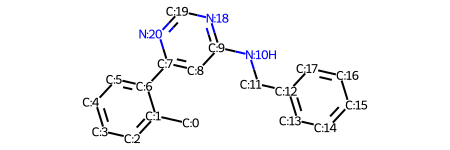

To optimize the above molecule to be less toxic, GAFSE Modifies the <11>-th atom to the element of <N> with the probability of <0.743>:
>>> Cc1ccccc1-c1cc(NNc2ccccc2)ncn1


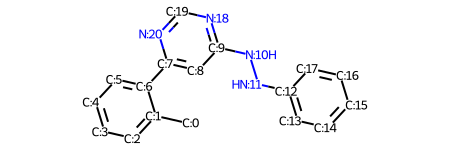

Molecule known to have lower toxicity:
>>> Cc1ccccc1-c1cc(NCc2cccnc2)ncn1


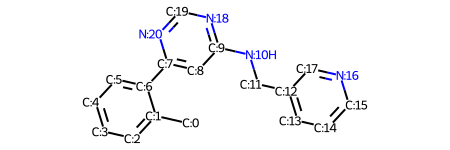

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.111, 'P': 0.056, 'S': 0.049, 'Cl': 0.052, 'As': 0.06, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.055, 'At': 0.054, 'other': 0.132} 
------------------------------------------------------------------------------------------------------------
atom#7(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#7(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.111, 'P': 0.056, 'S': 0.05, 'Cl': 0.052, 'As': 0.059, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.055, 'At': 0.054, 'other': 0.133} 
-------------------------------------------------------------------------------

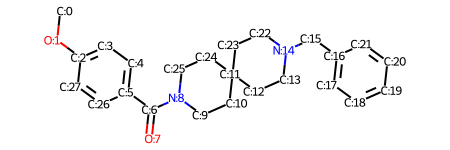

To optimize the above molecule to be less toxic, GAFSE Modifies the <14>-th atom to the element of <S> with the probability of <0.431>:
>>> COc1ccc(C(=O)N2CCC3(CC2)CC[SH](Cc2ccccc2)CC3)cc1


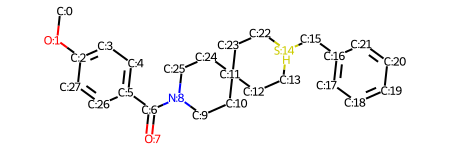

Molecule known to have lower toxicity:
>>> COc1ccc(C(=O)N2CCC3(CCN(Cc4ccncc4)CC3)CC2)cc1


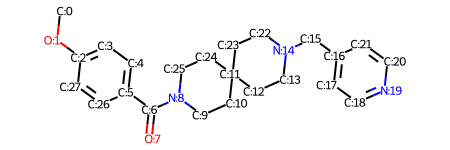

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.001, 'C': 0.014, 'N': 0.026, 'O': 0.024, 'F': 0.88, 'Si': 0.001, 'P': 0.001, 'S': 0.017, 'Cl': 0.028, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
atom#6(f+d): {'B': 0.001, 'C': 0.014, 'N': 0.026, 'O': 0.024, 'F': 0.88, 'Si': 0.001, 'P': 0.001, 'S': 0.017, 'Cl': 0.028, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
---------------------------------------------------------------------------------

atom#29(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#29(f+d): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
i: 2 top_idx: 0 rank: 0
The confidence of generating other elements on the 29-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 1 rank: 0
The confidence of generating other elements on the 22-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 2 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 3 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, findin

The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 8 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 9 rank: 0
The confidence of generating other elements on the 10-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 10 rank: 0
The confidence of generating other elements on the 11-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 11 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 12 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 13 rank: 0
The confidence of generating other elements on the 17-th atom is less than 0.001, finding the next atom...
i: 3 top_idx: 14 rank: 0
The confidence of generating other elements on the 18-th atom is less than 0.001

The confidence of generating other elements on the 10-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 4 rank: 0
The confidence of generating other elements on the 1-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 5 rank: 0
The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 6 rank: 0
The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 7 rank: 0
The confidence of generating other elements on the 12-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 8 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 9 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 10 rank: 0
The confidence of generating other elements on the 15-th atom is less than 0.001, fin

The confidence of generating other elements on the 24-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 1 rank: 0
Modifying the 23-th atom to the element of C does not meet the specification, generating the next element...
i: 5 top_idx: 1 rank: 1
Molecule known to be highly toxic:
>>> O=c1c(-c2ccc(F)cc2)nc2cnc(N3CCOCC3)nc2n1Cc1ccc(F)cc1


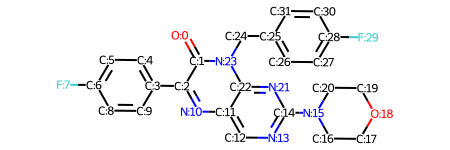

To optimize the above molecule to be less toxic, GAFSE Modifies the <23>-th atom to the element of <S> with the probability of <0.252>:
>>> O=C1C(c2ccc(F)cc2)NC2CNC(N3CCOCC3)NC2[SH]1Cc1ccc(F)cc1


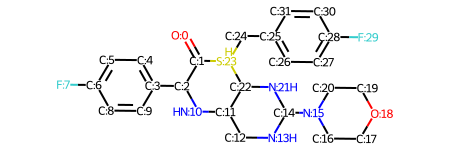

Molecule known to have lower toxicity:
>>> O=c1c(-c2ccc(F)cc2)nc2cnc(N3CCNCC3)nc2n1Cc1ccc(F)cc1


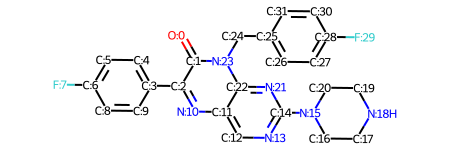

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.048, 'C': 0.098, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.117, 'P': 0.05, 'S': 0.034, 'Cl': 0.084, 'As': 0.047, 'Se': 0.102, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.056, 'other': 0.129} 
------------------------------------------------------------------------------------------------------------
atom#10(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.048, 'C': 0.097, 'N': 0.0, 'O': 0.002, 'F': 0.11, 'Si': 0.117, 'P': 0.05, 'S': 0.034, 'Cl': 0.085, 'As': 0.047, 'Se': 0.102, 'Br': 0.022, 'Te': 0.049, 'I': 0.052, 'At': 0.056, 'other': 0.129} 
-----------------------------------------------------------------------------------

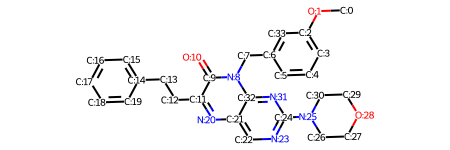

To optimize the above molecule to be less toxic, GAFSE Modifies the <28>-th atom to the element of <C> with the probability of <1.000>:
>>> COc1cccc(Cn2c(=O)c(CCc3ccccc3)nc3cnc(N4CCCCC4)nc32)c1


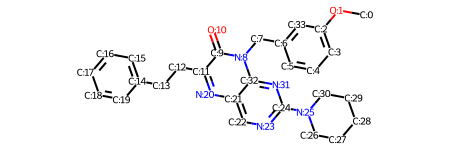

Molecule known to have lower toxicity:
>>> COc1cccc(Cn2c(=O)c(CCc3ccccc3)nc3cnc(N4CCNCC4)nc32)c1


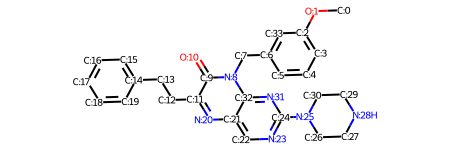

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B

The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 5 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 6 rank: 0
The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 7 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 8 rank: 0
The confidence of generating other elements on the 10-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 9 rank: 0
The confidence of generating other elements on the 12-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 10 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 7 top_idx: 11 rank: 0
The confidence of generating other elements on the 17-th atom is less than 0.001, fin

The confidence of generating other elements on the 1-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 4 rank: 0
The confidence of generating other elements on the 3-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 5 rank: 0
The confidence of generating other elements on the 4-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 6 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 7 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 8 rank: 0
The confidence of generating other elements on the 10-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 9 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 8 top_idx: 10 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, findi

atom#10(f): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#10(f+d): {'B': 0.0, 'C': 0.995, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#17(f): {'B': 0.0, 'C': 0.0, 'N': 0.995, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#17(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.995, 'O': 0.0, 'F': 0.004, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.0, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#21(f): {'

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.107, 'Si': 0.108, 'P': 0.057, 'S': 0.056, 'Cl': 0.048, 'As': 0.059, 'Se': 0.107, 'Br': 0.028, 'Te': 0.064, 'I': 0.053, 'At': 0.055, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.001, 'C': 0.013, 'N': 0.03, 'O': 0.026, 'F': 0.876, 'Si': 0.001, 'P': 0.001, 'S': 0.018, 'Cl': 0.026, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
atom#6(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.107, 'Si': 0.108, 'P': 0.057, 'S': 0.056, 'Cl': 0.048, 'As': 0.059, 'Se': 0.107, 'Br': 0.028, 'Te': 0.064, 'I': 0.053, 'At': 0.055, 'other': 0.131} 
----------------------------------------------------

atom#12(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#12(f+d): {'B': 0.055, 'C': 0.068, 'N': 0.002, 'O': 0.001, 'F': 0.107, 'Si': 0.108, 'P': 0.058, 'S': 0.056, 'Cl': 0.047, 'As': 0.059, 'Se': 0.107, 'Br': 0.028, 'Te': 0.064, 'I': 0.053, 'At': 0.056, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#15(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.002, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#15(f+d): {'B': 0.055, 'C': 0.068, 'N': 0.002, 'O': 0.001, 'F': 0.107, 'Si': 0.108, 'P': 0.058, 'S': 0.056, 'Cl': 0.047, 'As': 0.059, 'Se': 0.107, 'Br': 0.028, 'Te': 0.064, 'I': 0.053, 'At': 0.056, 'other': 0.131} 
-------------------------------------------------------------------------

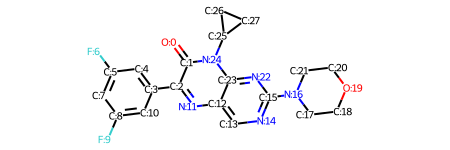

To optimize the above molecule to be less toxic, GAFSE Modifies the <16>-th atom to the element of <C> with the probability of <0.277>:
>>> O=c1c(-c2cc(F)cc(F)c2)nc2cnc(C3CCOCC3)nc2n1C1CC1


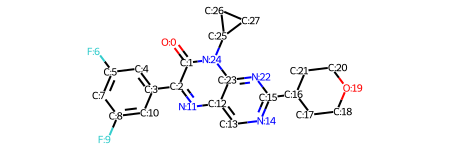

Molecule known to have lower toxicity:
>>> O=c1c(-c2cc(F)cc(F)c2)nc2cnc(N3CCNCC3)nc2n1C1CC1


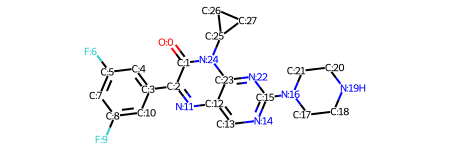

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.053, 'C': 0.086, 'N': 0.0, 'O': 0.006, 'F': 0.056, 'Si': 0.12, 'P': 0.068, 'S': 0.053, 'Cl': 0.068, 'As': 0.058, 'Se': 0.092, 'Br': 0.018, 'Te': 0.042, 'I': 0.076, 'At': 0.036, 'other': 0.168} 
------------------------------------------------------------------------------------------------------------
atom#19(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#19(f+d): {'B': 0.046, 'C': 0.094, 'N': 0.0, 'O': 0.002, 'F': 0.117, 'Si': 0.113, 'P': 0.049, 'S': 0.035, 'Cl': 0.094, 'As': 0.048, 'Se': 0.098, 'Br': 0.022, 'Te': 0.048, 'I': 0.051, 'At': 0.054, 'other': 0.128} 
--------------------------------------------------------------------------------

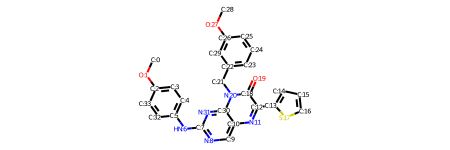

To optimize the above molecule to be less toxic, GAFSE Modifies the <1>-th atom to the element of <C> with the probability of <1.000>:
>>> CCc1ccc(Nc2ncc3nc(-c4cccs4)c(=O)n(Cc4cccc(OC)c4)c3n2)cc1


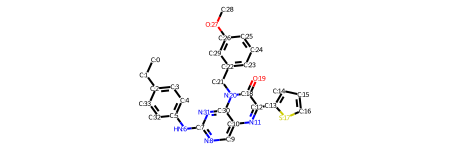

Molecule known to have lower toxicity:
>>> COc1ccc(Oc2ncc3nc(-c4cccs4)c(=O)n(Cc4cccc(OC)c4)c3n2)cc1


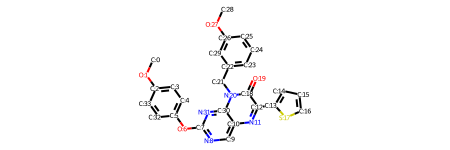

atom#0(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.05, 'C': 0.081, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.117, 'P': 0.05, 'S': 0.035, 'Cl': 0.085, 'As': 0.05, 'Se': 0.102, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.131} 
------------------------------------------------------------------------------------------------------------
atom#1(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#1(f+d): {'B': 0.05, 'C': 0.081, 'N': 0.0, 'O': 0.002, 'F': 0.113, 'Si': 0.117, 'P': 0.05, 'S': 0.035, 'Cl': 0.085, 'As': 0.05, 'Se': 0.102, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.054, 'other': 0.131} 
---------------------------------------------------------------------------------

The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 4 rank: 0
The confidence of generating other elements on the 12-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 5 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 6 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 7 rank: 0
The confidence of generating other elements on the 11-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 8 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 9 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, finding the next atom...
i: 2 top_idx: 10 rank: 0
The confidence of generating other elements on the 10-th atom is less than 0.001, fin

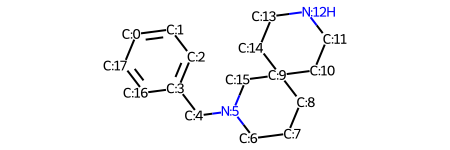

To optimize the above molecule to be less toxic, GAFSE Modifies the <4>-th atom to the element of <S> with the probability of <0.108>:
>>> c1ccc(SN2CCCC3(CCNCC3)C2)cc1


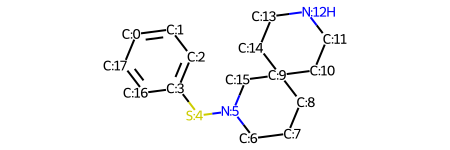

Molecule known to have lower toxicity:
>>> c1cc(CN2CCCC3(CCNCC3)C2)ccn1


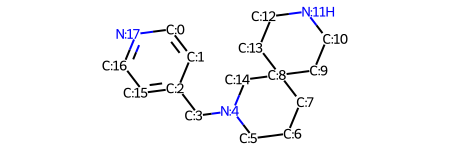

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.054, 'C': 0.093, 'N': 0.0, 'O': 0.006, 'F': 0.054, 'Si': 0.12, 'P': 0.064, 'S': 0.053, 'Cl': 0.064, 'As': 0.058, 'Se': 0.095, 'Br': 0.017, 'Te': 0.043, 'I': 0.078, 'At': 0.035, 'other': 0.167} 
------------------------------------------------------------------------------------------------------------
atom#3(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#3(f+d): {'B': 0.05, 'C': 0.082, 'N': 0.0, 'O': 0.002, 'F': 0.114, 'Si': 0.115, 'P': 0.05, 'S': 0.033, 'Cl': 0.086, 'As': 0.05, 'Se': 0.102, 'Br': 0.024, 'Te': 0.051, 'I': 0.055, 'At': 0.053, 'other': 0.132} 
-------------------------------------------------------------------------------------

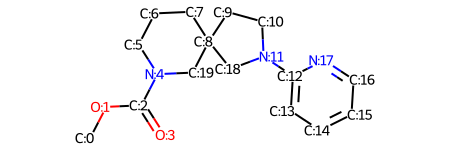

To optimize the above molecule to be less toxic, GAFSE Modifies the <1>-th atom to the element of <P> with the probability of <1.000>:
>>> CPC(=O)N1CCCC2(CCN(c3ccccn3)C2)C1


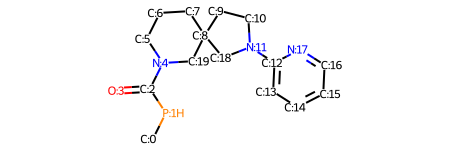

Molecule known to have lower toxicity:
>>> COC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1


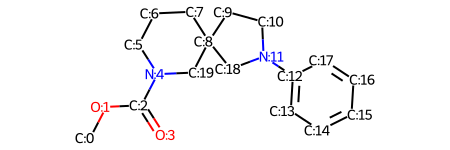

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#5(f): {'B

The confidence of generating other elements on the 4-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 3 rank: 0
The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 4 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 5 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 6 rank: 0
The confidence of generating other elements on the 8-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 7 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 8 rank: 0
The confidence of generating other elements on the 11-th atom is less than 0.001, finding the next atom...
i: 4 top_idx: 9 rank: 0
The confidence of generating other elements on the 12-th atom is less than 0.001, finding

The confidence of generating other elements on the 5-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 5 rank: 0
The confidence of generating other elements on the 6-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 6 rank: 0
The confidence of generating other elements on the 7-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 7 rank: 0
The confidence of generating other elements on the 9-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 8 rank: 0
The confidence of generating other elements on the 10-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 9 rank: 0
The confidence of generating other elements on the 12-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 10 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 5 top_idx: 11 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, fin

>>> N#Cc1cccc(-c2cc(NCc3ccccc3)ncn2)c1


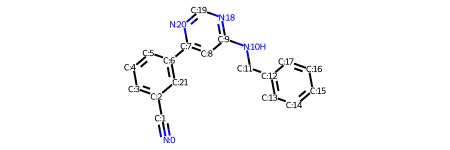

To optimize the above molecule to be less toxic, GAFSE Modifies the <0>-th atom to the element of <C> with the probability of <1.000>:
>>> C#Cc1cccc(-c2cc(NCc3ccccc3)ncn2)c1


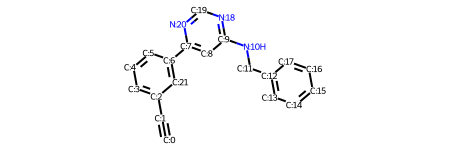

Molecule known to have lower toxicity:
>>> N#Cc1cccc(-c2cc(NCc3cccnc3)ncn2)c1


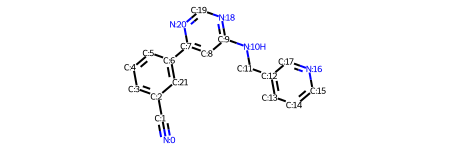

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.041, 'C': 0.135, 'N': 0.0, 'O': 0.001, 'F': 0.108, 'Si': 0.107, 'P': 0.05, 'S': 0.037, 'Cl': 0.089, 'As': 0.044, 'Se': 0.094, 'Br': 0.018, 'Te': 0.046, 'I': 0.045, 'At': 0.057, 'other': 0.128} 
------------------------------------------------------------------------------------------------------------
atom#4(f): {'B': 0.0, 'C': 0.997, 'N': 0.0, 'O': 0.0, 'F': 0.001, 'Si': 0.0, 'P': 0.0, 'S': 0.001, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#4(f+d): {'B': 0.04, 'C': 0.139, 'N': 0.0, 'O': 0.001, 'F': 0.107, 'Si': 0.106, 'P': 0.05, 'S': 0.038, 'Cl': 0.088, 'As': 0.043, 'Se': 0.094, 'Br': 0.018, 'Te': 0.046, 'I': 0.044, 'At': 0.057, 'other': 0.129} 
--------------------------------------------------------------------------------

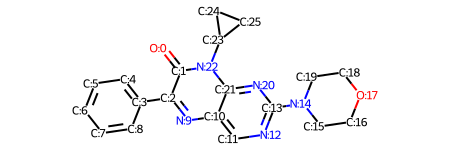

To optimize the above molecule to be less toxic, GAFSE Modifies the <12>-th atom to the element of <P> with the probability of <1.000>:
>>> O=c1c(-c2ccccc2)nc2cpc(N3CCOCC3)nc2n1C1CC1


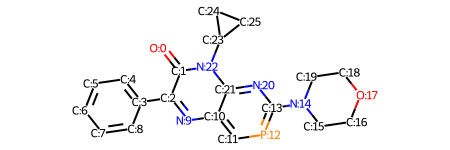

Molecule known to have lower toxicity:
>>> O=c1c(-c2ccccc2)nc2cnc(N3CCNCC3)nc2n1C1CC1


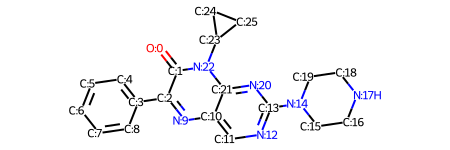

atom#0(f): {'B': 0.0, 'C': 0.998, 'N': 0.0, 'O': 0.0, 'F': 0.0, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.052, 'C': 0.08, 'N': 0.0, 'O': 0.002, 'F': 0.112, 'Si': 0.117, 'P': 0.05, 'S': 0.034, 'Cl': 0.08, 'As': 0.051, 'Se': 0.104, 'Br': 0.025, 'Te': 0.051, 'I': 0.056, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#6(f+d): {'B': 0.052, 'C': 0.079, 'N': 0.0, 'O': 0.002, 'F': 0.112, 'Si': 0.117, 'P': 0.05, 'S': 0.033, 'Cl': 0.081, 'As': 0.051, 'Se': 0.103, 'Br': 0.025, 'Te': 0.051, 'I': 0.056, 'At': 0.054, 'other': 0.133} 
-------------------------------------------------------------------------------------

>>> COCCn1c(=O)c(-c2ccc(OC)cc2)nc2cnc(Nc3ccccc3)nc21


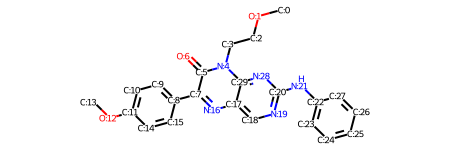

To optimize the above molecule to be less toxic, GAFSE Modifies the <12>-th atom to the element of <C> with the probability of <1.000>:
>>> CCc1ccc(-c2nc3cnc(Nc4ccccc4)nc3n(CCOC)c2=O)cc1


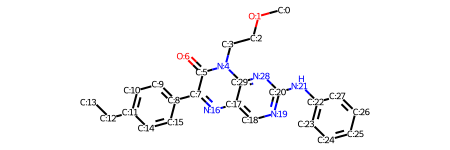

Molecule known to have lower toxicity:
>>> COCCn1c(=O)c(-c2ccc(OC)cc2)nc2cnc(Oc3ccccc3)nc21


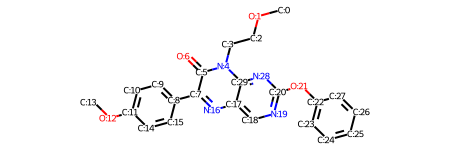

atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.111, 'P': 0.056, 'S': 0.05, 'Cl': 0.052, 'As': 0.059, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.055, 'At': 0.054, 'other': 0.133} 
------------------------------------------------------------------------------------------------------------
atom#18(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#18(f+d): {'B': 0.055, 'C': 0.069, 'N': 0.001, 'O': 0.001, 'F': 0.104, 'Si': 0.111, 'P': 0.056, 'S': 0.05, 'Cl': 0.052, 'As': 0.059, 'Se': 0.109, 'Br': 0.027, 'Te': 0.064, 'I': 0.055, 'At': 0.054, 'other': 0.133} 
---------------------------------------------------------------------------

>>> O=C(NCC1CCCO1)C(c1cccnc1)N(C(=O)Cc1cccs1)c1cccnc1


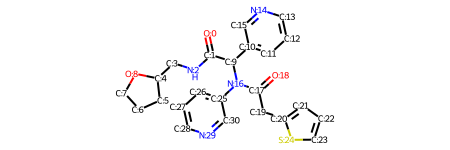

To optimize the above molecule to be less toxic, GAFSE Modifies the <2>-th atom to the element of <C> with the probability of <0.524>:
>>> O=C(CCC1CCCO1)C(c1cccnc1)N(C(=O)Cc1cccs1)c1cccnc1


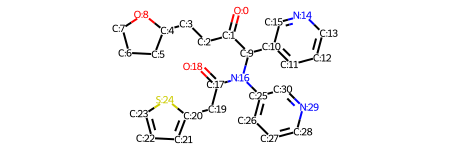

Molecule known to have lower toxicity:
>>> O=C(NCC1CCCO1)C(c1cccnc1)N(C(=O)Cc1cccs1)c1ccccc1


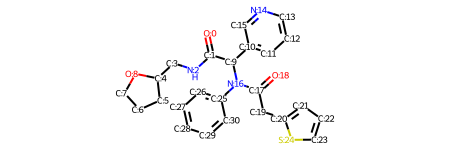

congratulations: [2] [34]
atom#0(f): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
atom#0(f+d): {'B': 0.0, 'C': 0.0, 'N': 0.0, 'O': 0.997, 'F': 0.002, 'Si': 0.0, 'P': 0.0, 'S': 0.0, 'Cl': 0.001, 'As': 0.0, 'Se': 0.0, 'Br': 0.0, 'Te': 0.0, 'I': 0.0, 'At': 0.0, 'other': 0.0} 
------------------------------------------------------------------------------------------------------------
atom#6(f): {'B': 0.001, 'C': 0.013, 'N': 0.028, 'O': 0.023, 'F': 0.881, 'Si': 0.001, 'P': 0.001, 'S': 0.018, 'Cl': 0.026, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
atom#6(f+d): {'B': 0.001, 'C': 0.013, 'N': 0.028, 'O': 0.023, 'F': 0.881, 'Si': 0.001, 'P': 0.001, 'S': 0.018, 'Cl': 0.026, 'As': 0.001, 'Se': 0.001, 'Br': 0.0, 'Te': 0.001, 'I': 0.003, 'At': 0.001, 'other': 0.002} 
-----------------------------------------------------

The confidence of generating other elements on the 11-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 8 rank: 0
The confidence of generating other elements on the 13-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 9 rank: 0
The confidence of generating other elements on the 14-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 10 rank: 0
The confidence of generating other elements on the 17-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 11 rank: 0
The confidence of generating other elements on the 18-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 12 rank: 0
The confidence of generating other elements on the 19-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 13 rank: 0
The confidence of generating other elements on the 20-th atom is less than 0.001, finding the next atom...
i: 0 top_idx: 14 rank: 0
The confidence of generating other elements on the 21-th atom is less than 0.0

In [29]:
stopper.load_checkpoint(model)
stopper_afse.load_checkpoint(amodel)
stopper_generate.load_checkpoint(gmodel)

# torch.save({'model_state_dict': model.state_dict()}, model_file + '_model_test.pth')
# torch.save({'model_state_dict': amodel.state_dict()}, model_file + '_amodel_test.pth')
# torch.save({'model_state_dict': gmodel.state_dict()}, model_file + '_gmodel_test.pth')
    
reconstruction_rate, success_validity, unique_rate, novelty_rate, success_smiles, init_smiles, generated_smiles, test_predict = eval(model, amodel, gmodel, test_df, topn=1, generate=True, validate=True, print_flag=True)

test_predict = np.array(test_predict)

print("----------")
print('Reconstruction: %.4f'%reconstruction_rate,'\nValidity: %.4f'%success_validity)
print('Unique: %.4f'%unique_rate,'\nNovelty: %.4f'%novelty_rate, 
      '\nAverage: %.4f'%((reconstruction_rate+success_validity+unique_rate+novelty_rate)/4))

In [30]:
print(len(init_smiles))
print(init_smiles)

34
['COc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(-c3ccccc3)c2=O)cc1', 'COCCn1c(=O)c(CCc2ccccc2)nc2cnc(N3CCOCC3)nc21', 'CN(C)CCCN1c2ccccc2Sc2ccccc21', 'Cc1ccccc1-c1nc(CS(=O)CC(=O)N2CCC3(CC2)OCCO3)c(C)o1', 'O=S(=O)(c1ccccc1)N1CCC2(CCN(Cc3ccccc3)CC2)CC1', 'O=c1c(CCc2ccccc2)nc2cnc(N3CCOCC3)nc2n1CCc1ccccc1', 'Cc1noc(C)c1C(=O)N1CCCC2(CCN(c3ncccn3)C2)C1', 'O=C(c1ccncc1)N1CCC2(CCCN(c3ccncc3)C2)CC1', 'CN(C)C(=O)c1ccc(-c2cc(NCc3ccccc3)ncn2)cc1', 'COCCn1c(=O)c(-c2ccc(Cl)cc2)nc2cnc(N3CCOCC3)nc21', 'O=c1c(-c2ccc(F)cc2)nc2cnc(N3CCOCC3)nc2n1C1CC1', 'COCCn1c(=O)c(-c2ccc(OC)cc2)nc2cnc(N3CCOCC3)nc21', 'CN(C)C(=O)c1ccc(-c2ccc3ncnc(N4CCNCC4)c3c2)cc1', 'O=C(O)c1ccccc1C(=O)NCc1ccc(F)cc1', 'COCC(=O)N1CCCC2(CCN(c3ccccn3)C2)C1', 'Cc1noc(C)c1-c1cc(NCc2ccccc2)ncn1', 'COc1ccccc1-c1cc(NCc2ccccc2)ncn1', 'CCc1cccc2c(C=C(C#N)C#N)cn(CC(=O)N3CCCCC3)c12', 'O=c1c(CCc2ccccc2)nc2cnc(N3CCOCC3)nc2n1Cc1cccs1', 'COc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)cc1', 'COCCn1c(=O)c(-c2cccc(C#N)c2)nc2cnc(N3CCOCC3)nc21', 'CCCCSc1nnc(-c2cc3c(C(F)(F)

In [31]:
print(len(generated_smiles))
print(generated_smiles)

34
['CCc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(-c3ccccc3)c2=O)cc1', 'COCC[SH]1C(=O)C(CCc2ccccc2)NC2CNC(N3CCOCC3)NC21', 'CN(C)[IH]CCN1c2ccccc2Sc2ccccc21', 'Cc1ccccc1[SiH]1CC(C)C(CS(=O)CC(=O)N2CCC3(CC2)OCCO3)N1', 'O=S(=O)(c1ccccc1)N1CCC2(CCC(Cc3ccccc3)CC2)CC1', 'O=c1c(CCc2ccccc2)nc2cnc(N3CCCCC3)nc2n1CCc1ccccc1', 'CC1CCC(C)C1C(=O)N1CCCC2(CCN(c3ncccn3)C2)C1', 'O=C(c1ccncc1)N1CCC2(CCCN(c3ccccc3)C2)CC1', 'CN(C)C(=O)c1ccc(-c2cc(CCc3ccccc3)ncn2)cc1', 'COCCn1c(=O)c(-c2ccc(Cl)cc2)nc2cnc(N3CCCCC3)nc21', 'O=c1c(-c2ccc(F)cc2)nc2ccc(N3CCOCC3)nc2n1C1CC1', 'COCCn1c(=[IH])c(-c2ccc(OC)cc2)nc2cnc(N3CCOCC3)nc21', 'CN(C)C(=O)c1ccc(-c2ccc3ncnc(C4CCNCC4)c3c2)cc1', 'O=C(O)c1ccccc1C(=O)CCc1ccc(F)cc1', 'COCC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1', 'Cc1noc(C)c1-c1cc(CCc2ccccc2)ncn1', 'COc1ccccc1-c1cc(SCc2ccccc2)ncn1', 'C#CC(C#N)=Cc1cn(CC(=O)N2CCCCC2)c2c(CC)cccc12', 'O=C1C(CCc2ccccc2)NC2CNC(N3CCOCC3)NC2C1Cc1cccs1', 'CCc1ccc(-c2nc3cnc(N4CCOCC4)nc3n(C3CC3)c2=O)cc1', 'C#Cc1cccc(-c2nc3cnc(N4CCOCC4)nc3n(CCOC)c2=O)c1', 'CCCCSc1nnc(-c2cc

In [32]:
print(len(success_smiles))
print(success_smiles)

2
['O=C(c1ccncc1)N1CCC2(CCCN(c3ccccc3)C2)CC1', 'COCC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1']


In [33]:
import math
import pickle
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
import os
import os.path as op
 
#get_sa_score start
_fscores = None
 
def readFragmentScores(name='fpscores'):
    import gzip
    global _fscores
    # generate the full path filename:
    if name == "fpscores":
        name = op.join(os.getcwd(), name)
        # name = op.join(op.dirname(__file__), name)
    data = pickle.load(gzip.open('%s.pkl.gz' % name))
    outDict = {}
    for i in data:
        for j in range(1, len(i)):
            outDict[i[j]] = float(i[0])
    _fscores = outDict
 
 
def numBridgeheadsAndSpiro(mol, ri=None):
    nSpiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    nBridgehead = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    return nBridgehead, nSpiro
 
def calculateScore(m):
    if _fscores is None:
        readFragmentScores()
 
    # fragment score
    fp = rdMolDescriptors.GetMorganFingerprint(m,
                                            2)  # <- 2 is the *radius* of the circular fingerprint
    fps = fp.GetNonzeroElements()
    score1 = 0.
    nf = 0
    for bitId, v in fps.items():
        nf += v
        sfp = bitId
        score1 += _fscores.get(sfp, -4) * v
    score1 /= nf
 
    # features score
    nAtoms = m.GetNumAtoms()
    nChiralCenters = len(Chem.FindMolChiralCenters(m, includeUnassigned=True))
    ri = m.GetRingInfo()
    nBridgeheads, nSpiro = numBridgeheadsAndSpiro(m, ri)
    nMacrocycles = 0
    for x in ri.AtomRings():
        if len(x) > 8:
            nMacrocycles += 1
 
    sizePenalty = nAtoms**1.005 - nAtoms
    stereoPenalty = math.log10(nChiralCenters + 1)
    spiroPenalty = math.log10(nSpiro + 1)
    bridgePenalty = math.log10(nBridgeheads + 1)
    macrocyclePenalty = 0.
    # ---------------------------------------
    # This differs from the paper, which defines:
    # macrocyclePenalty = math.log10(nMacrocycles+1)
    # This form generates better results when 2 or more macrocycles are present
    if nMacrocycles > 0:
        macrocyclePenalty = math.log10(2)
 
    score2 = 0. - sizePenalty - stereoPenalty - spiroPenalty - bridgePenalty - macrocyclePenalty
 
    # correction for the fingerprint density
    # not in the original publication, added in version 1.1
    # to make highly symmetrical molecules easier to synthetise
    score3 = 0.
    if nAtoms > len(fps):
        score3 = math.log(float(nAtoms) / len(fps)) * .5
 
    sascore = score1 + score2 + score3
 
    # need to transform "raw" value into scale between 1 and 10
    min = -4.0
    max = 2.5
    sascore = 11. - (sascore - min + 1) / (max - min) * 9.
    # smooth the 10-end
    if sascore > 8.:
        sascore = 8. + math.log(sascore + 1. - 9.)
    if sascore > 10.:
        sascore = 10.0
    elif sascore < 1.:
        sascore = 1.0
 
    return sascore

def SA_score(mols:list):
    ss = []
    drop_index = []
    readFragmentScores("fpscores")
#     print('smiles\tsa_score')
    for i, m in enumerate(mols):
        try:
            s = calculateScore(m)
            smiles = Chem.MolToSmiles(m)
            ss.append(s)
        except:
            print(f'Cannot read {m}')
            drop_index.append(i)
    return drop_index, ss

In [34]:
QED_scores_init = []
logP_scores_init = []
init_mols = []
smiles_num = len(init_smiles)
init_smiles_new = init_smiles
for i in range(smiles_num):
    try:
        mol = Chem.MolFromSmiles(init_smiles[i])
        init_mols.append(mol)
        QED = Chem.QED.default(mol)
        QED_scores_init.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores_init.append(logP)
    except:
        print(f'Cannot read {init_smiles[i]}')
        init_smiles_new.pop(i)
init_mols_new = init_mols
drop_index, SA_scores_init = np.array(SA_score(init_mols))
for i in drop_index:
    init_mols_new.pop(i)
    init_smiles_new.pop(i)
QED_scores_init = np.array(QED_scores_init)
QED_scores_init_ranked = np.sort(QED_scores_init)
logP_scores_init = np.array(logP_scores_init)

QED_scores = []
logP_scores = []
generated_mols = []
smiles_num = len(generated_smiles)
generated_smiles_new = generated_smiles
for i in range(smiles_num):
    try:
        mol = Chem.MolFromSmiles(generated_smiles[i])
        generated_mols.append(mol)
        QED = Chem.QED.default(mol)
        QED_scores.append(QED)
        logP = Chem.Crippen.MolLogP(mol)
        logP_scores.append(logP)
    except:
        print(f'Cannot read {generated_smiles[i]}')
        generated_smiles_new.pop(i)
        init_smiles_new.pop(i)
        init_mols_new.pop(i)
generated_mols_new = generated_mols
drop_index, SA_scores = np.array(SA_score(generated_mols))
for i in drop_index:
    generated_smiles_new.pop(i)
    generated_mols_new.pop(i)
    init_smiles_new.pop(i)
    init_mols_new.pop(i)
QED_scores = np.array(QED_scores)
QED_scores_ranked = np.sort(QED_scores)
logP_scores = np.array(logP_scores)
print('QED Rank:', QED_scores_ranked[-5:],
      '\nQED（越大类药性越高）: %.4f'%max(QED_scores), '%.4f'%(sum(QED_scores)/smiles_num),'%.4f'%min(QED_scores),
      '\nSA（越小可合成性越高）: %.4f'%max(SA_scores), '%.4f'%(sum(SA_scores)/smiles_num),'%.4f'%min(SA_scores),
      '\nlogP（越大疏水性越好）: %.4f'%max(logP_scores), '%.4f'%(sum(logP_scores)/smiles_num),'%.4f'%min(logP_scores),
      )

/data/yinmingyue/anaconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


QED Rank: [0.82428464 0.82897479 0.84116617 0.84919372 0.85418752] 
QED（越大类药性越高）: 0.8542 0.6406 0.3493 
SA（越小可合成性越高）: 5.3274 2.9568 1.6813 
logP（越大疏水性越好）: 5.2779 3.2820 0.2685


/data/yinmingyue/anaconda3/envs/env/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [41]:
I_SMILES_Dict = {init_smiles_new[i]: [QED_scores_init[i], SA_scores_init[i], logP_scores_init[i]] for i in range(len(init_smiles_new))}
G_SMILES_Dict = {generated_smiles_new[i]: [QED_scores[i], SA_scores[i], logP_scores[i]] for i in range(len(generated_smiles_new))}
for i, smiles in enumerate(success_smiles):
    index = generated_smiles_new.index(smiles)
    matched_init_smiles = 'COCC(=O)N1CCCC2(CCN(c3ccccn3)C2)C1'
    for j in range(len(init_smiles_new)):
        same = 0
        anchor = smiles
        smi = init_smiles_new[j]
        length = np.min([len(anchor),len(smi)])
        for k in range(length):
            if anchor[k] == smi[k]:
                same += 1
        if same == length-1 and len(anchor)==len(smi):
            matched_init_smiles = smi
            try:
                print('原始测试集分子：',matched_init_smiles,
                      '\n原始测试集分子毒性：%.4f'%(train_df['value'].values[train_df.cano_smiles.values==matched_init_smiles][0].astype(float)),
                     '\nQED（越大类药性越高）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][0],
                      '\nSA（越小可合成性越高）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][1],
                      '\nlogP（越大疏水性越好）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][2],
                     '\n\n成功生成的高活性分子：',smiles,
                      '\n毒性（1有毒0无毒）: %.4f'%(test_df['value'].values[test_df.cano_smiles.values==smiles][0].astype(float)),
                     '\nQED（越大类药性越高）: %.4f'%G_SMILES_Dict[smiles][0],
                      '\nSA（越小可合成性越高）: %.4f'%G_SMILES_Dict[smiles][1],
                      '\nlogP（越大疏水性越好）: %.4f'%G_SMILES_Dict[smiles][2],
                     '\n------------------------------------------------------------------------------------------------------------')
            except:
                print('原始测试集分子：',matched_init_smiles,
                      '\n原始测试集分子毒性：%.4f'%(val_df['value'].values[val_df.cano_smiles.values==matched_init_smiles][0].astype(float)),
                     '\nQED（越大类药性越高）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][0],
                      '\nSA（越小可合成性越高）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][1],
                      '\nlogP（越大疏水性越好）: %.4f'%I_SMILES_Dict[init_smiles_new[index]][2],
                     '\n\n成功生成的高活性分子：',smiles,
                      '\n毒性（1有毒0无毒）: %.4f'%(test_df['value'].values[test_df.cano_smiles.values==smiles][0].astype(float)),
                     '\nQED（越大类药性越高）: %.4f'%G_SMILES_Dict[smiles][0],
                      '\nSA（越小可合成性越高）: %.4f'%G_SMILES_Dict[smiles][1],
                      '\nlogP（越大疏水性越好）: %.4f'%G_SMILES_Dict[smiles][2],
                     '\n------------------------------------------------------------------------------------------------------------')
                continue

原始测试集分子： O=C(c1ccncc1)N1CCC2(CCCN(c3ccncc3)C2)CC1 
原始测试集分子毒性：0.0000 
QED（越大类药性越高）: 0.8458 
SA（越小可合成性越高）: 2.8367 
logP（越大疏水性越好）: 2.9994 

成功生成的高活性分子： O=C(c1ccncc1)N1CCC2(CCCN(c3ccccc3)C2)CC1 
毒性（1有毒0无毒）: 1.0000 
QED（越大类药性越高）: 0.8412 
SA（越小可合成性越高）: 2.6357 
logP（越大疏水性越好）: 3.6044 
------------------------------------------------------------------------------------------------------------
原始测试集分子： COCC(=O)N1CCCC2(CCN(c3ccccn3)C2)C1 
原始测试集分子毒性：0.0000 
QED（越大类药性越高）: 0.8467 
SA（越小可合成性越高）: 3.2989 
logP（越大疏水性越好）: 1.5469 

成功生成的高活性分子： COCC(=O)N1CCCC2(CCN(c3ccccc3)C2)C1 
毒性（1有毒0无毒）: 1.0000 
QED（越大类药性越高）: 0.8542 
SA（越小可合成性越高）: 3.1168 
logP（越大疏水性越好）: 2.1519 
------------------------------------------------------------------------------------------------------------


In [21]:
# total_step = 1
# test_predict = []
# generated_smiles = []
# stopper.load_checkpoint(model)
# stopper_afse.load_checkpoint(amodel)
# stopper_generate.load_checkpoint(gmodel)
# total_smilesList = train_df['smiles'].values
# feature_dicts = save_smiles_dicts(total_smilesList,filename)
# generated_df = train_df
# for step in range(total_step):
#     _, _, _, _, _, _, generated_smiles_step, _, _, test_predict_step = eval(model, amodel, gmodel, generated_df, topn=1, generate=True)
#     test_predict.extend(test_predict_step)
#     generated_df = pd.DataFrame([])
#     generated_df['smiles'] = generated_smiles_step
#     generated_df['value'] = 0
#     generated_df = add_canonical_smiles(generated_df)
#     feature_dicts = save_smiles_dicts(generated_df['smiles'],filename)
#     generated_df = generated_df[generated_df["smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
#     generated_df = generated_df.reset_index(drop=True)
#     generated_smiles.extend(generated_df['smiles'])
# test_predict = np.array(test_predict)
# print(len(test_predict),len(generated_smiles))
# QED_scores = []
# logP_scores = []
# generated_mols = []
# smiles_num = len(generated_smiles)
# for i in range(smiles_num):
#     mol = Chem.MolFromSmiles(generated_smiles[i])
#     if mol is not None:
#         generated_mols.append(mol)
#         QED = Chem.QED.default(mol)
#         QED_scores.append(QED)
#         logP = Chem.Crippen.MolLogP(mol)
#         logP_scores.append(logP)
# SA_scores = np.array(SA_score(generated_mols))
# QED_scores = np.array(QED_scores)
# QED_scores_ranked = np.sort(QED_scores)
# logP_scores = np.array(logP_scores)
# print('QED Rank:', QED_scores_ranked[-5:],
#       '\nQED（越大类药性越高）: %.4f'%max(QED_scores), '%.4f'%(sum(QED_scores)/smiles_num),'%.4f'%min(QED_scores),
#       '\nSA（越小可合成性越高）: %.4f'%max(SA_scores), '%.4f'%(sum(SA_scores)/smiles_num),'%.4f'%min(SA_scores),
#       '\nlogP（越大疏水性越好）: %.4f'%max(logP_scores), '%.4f'%(sum(logP_scores)/smiles_num),'%.4f'%min(logP_scores),
#       )

In [22]:
# generated_df = pd.DataFrame([])
# generated_df['smiles'] = generated_smiles
# generated_df = add_canonical_smiles(generated_df)
# generated_df = generated_df.reset_index(drop=True)
# feature_dicts = save_smiles_dicts(generated_df['smiles'],filename)
# x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(generated_df['smiles'],feature_dicts)
# x_atom = torch.Tensor(x_atom)
# x_bonds = torch.Tensor(x_bonds)
# x_bond_index = torch.cuda.LongTensor(x_bond_index)
# mol_feature = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
# eps_adv, d_adv, vat_loss, mol_prediction = perturb_feature(mol_feature, amodel, alpha=1, lamda=10**-learning_rate)
# mol_prediction = np.array(mol_prediction.detach().cpu())
# test_predict_scores = mol_prediction
# generated_df['Predicted_Activity_Score'] = test_predict_scores
# generated_df['QED'] = QED_scores
# generated_df['SA'] = SA_scores
# generated_df['logP'] = logP_scores
# generated_df.to_csv(path_or_buf='./result/'+file1+'_generated_molecules.csv')
print(len(test_predict),len(generated_mols))
# G_SMILES_Dict = {generated_mols[i]: [QED_scores[i], SA_scores[i], logP_scores[i]] for i in range(len(generated_mols))}
# for i, mol in enumerate(generated_mols):
#     index = generated_mols.index(mol)
#     display(mol)
#     print('成功生成的高活性分子：',Chem.MolToSmiles(mol),
#           '\nActivity（越大药效越好）: %.4f'%test_predict_scores[index],
#          '\nQED（越大类药性越高）: %.4f'%G_SMILES_Dict[mol][0],
#           '\nSA（越小可合成性越高）: %.4f'%G_SMILES_Dict[mol][1],
#           '\nlogP（越大疏水性越好）: %.4f'%G_SMILES_Dict[mol][2],
#          '\n------------------------------------------------------------------------------------------------------------')

51 37


In [23]:
# stopper.load_checkpoint(model)
# stopper_afse.load_checkpoint(amodel)
# stopper_generate.load_checkpoint(gmodel)
# _, _, test_predict = eval(model, amodel, gmodel, test_df)
# test_predict = np.array(test_predict)
# test_df['predict_value'] = test_predict
# test_df.to_csv(path_or_buf='./result/'+file1+'_test_predict.csv')

In [24]:
# print('target_file:',task_filename)
# print('inactive_file:',test_filename)
# np.savez('./result/G_AFSE_'+file1, epoch_list, train_f_list, train_d_list, 
#          train_predict_list, train_y_list, val_f_list, val_d_list, val_predict_list, val_y_list, test_f_list, 
#          test_d_list, test_predict_list, test_y_list)
# sim_space = np.load('./result/G_AFSE_'+file1+".npz")
# print(sim_space['arr_10'].shape)

In [25]:
# 重构原子类型
# activated_features=activated_features